# Thematic Analyis

This notebook is a network analysis for exploring themes emerging from interviews and questionnaires.

Purpose:
- analysis of emerging themes, inspection on themes stability, retrieval of sentences supporting themes

Research strategy:
- Deductive/Inductive

Requirements:
- Excel/Google Sheets, with a sheet per respondent.
- Respondents' answers have been tokenised into sentences or paragraphs, one for each line.
- Sentences have been coded (inductively) : each line has a list of codes (comma separated)

Recommendation (Optional):
- Use a prototocol to map questions to areas of interests (classes).
- The protocol is used as preliminary guide to cover areas of interests deductively (e.g. inspect if the type questions and their distribution adequately covered the desired classes)
- Interviews are meant to be semistructured and follow the protocol
- Questionnaires are meant designed to include open questions that map to the protocol
- Respondents' answers are Coded
- Coding can be iterative: at each iteration, the research may want to coalish codes towards a desired level of granularity. Network analysis can work with hundreds of Codes - depending on the quality of granularity and coding saturation chosen by the researcher




# Load data (Google Sheets)

In [1]:
#!pip install gspread oauth2client

In [4]:
# mockup credential => create your own on Google Cloud API.

credentials = './api-project-000000000000-000000000000.json'

In [5]:
import gspread

sa = gspread.service_account(filename=credentials)

In [6]:
# mockup sheets - use the url of your Google Sheets
sheet = sa.open_by_url("https://docs.google.com/spreadsheets/d/my-google-sheet-url-000000000000000000000000/")

In [7]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Use of Classes (Deductive)

In [174]:
# Load the sheet with Questions mapped to Classes

work_sheet = sheet.worksheet("Questions (Classes)")

In [175]:
headers = ['Macro-Area', 'Descriptors (Classes)']
df = pd.DataFrame(work_sheet.get_all_records(expected_headers=headers))

In [176]:
counter = Counter(
    word.strip()
    for cell in df['Descriptors (Classes)'].dropna()
    for word in cell.split(',')
)

class_counts = pd.DataFrame(counter.items(), columns=['class', 'count'])

In [177]:
class_to_macro = (
    df
    .assign(class_=df['Descriptors (Classes)'].str.split(','))
    .explode('class_')
    .assign(class_=lambda x: x['class_'].str.strip())
    .set_index('class_')['Macro-Area']
    .to_dict()
)

class_to_macro.pop('')

''

In [178]:
# add macro-class column
class_counts['macro_class'] = class_counts['class'].map(class_to_macro)

# pivot for stacked bar plot
pivot = class_counts.pivot_table(
    index='macro_class',
    columns='class',
    values='count',
    fill_value=0
)

In [587]:
pivot.index

Index(['Communication of innovation', 'Data formats', 'Definitions',
       'Expectancy for micro-data collection', 'Perspectives',
       'Practice for measuring innovation', 'Resources and Requirements',
       'Role and Context', 'Tools for measuring innovation',
       'Traceability and Governance'],
      dtype='object', name='macro_class')

/var/folders/cs/z84f7knj6x56zgcmc1k0x41r0000gn/T/ipykernel_790/423039081.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = cm.get_cmap("tab10", len(macro_classes))
/var/folders/cs/z84f7knj6x56zgcmc1k0x41r0000gn/T/ipykernel_790/423039081.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


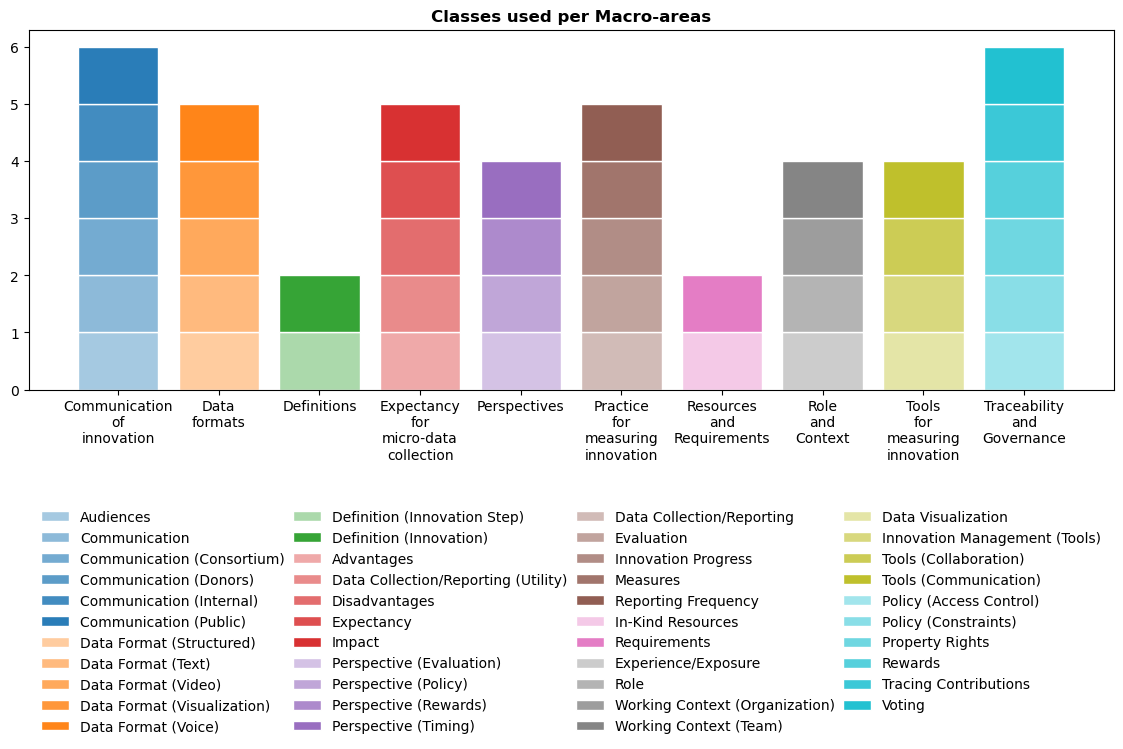

In [925]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

fig, ax = plt.subplots(figsize=(14, 6))

macro_classes = pivot.index.tolist()
base_cmap = cm.get_cmap("tab10", len(macro_classes))

bottom = np.zeros(len(macro_classes))
handles = []
labels = []

for i, macro in enumerate(macro_classes):
    classes = pivot.columns[pivot.loc[macro] > 0]
    counts = pivot.loc[macro, classes]

    base_color = base_cmap(i)
    cmap = mcolors.LinearSegmentedColormap.from_list(
        f"{macro}_grad",
        ["white", base_color]
    )
    colors = cmap(np.linspace(0.4, 0.95, len(classes)))

    for cls, cnt, col in zip(classes, counts, colors):
        bar = ax.bar(
            macro,
            cnt,
            bottom=bottom[i],
            color=col,
            edgecolor="white",
            linewidth=1.
        )
        bottom[i] += cnt
        handles.append(bar[0])
        #labels.append(f"{macro} - {cls}")
        labels.append(f"{cls}".title())

#ax.set_xlabel("Macro-class")
#ax.set_ylabel("Count")
ax.set_title("Classes used per Macro-areas", fontweight="bold")

ax.set_xticklabels(
    [label.replace(" ", "\n") for label in pivot.index],
    ha="center"
)

# reserve space explicitly for legend (key trick)
fig.subplots_adjust(bottom=0.28)

ax.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0, -0.3, 1, 0),
    bbox_transform=ax.transAxes,
    mode="expand",
    ncol=4,
    frameon=False
)

plt.savefig(
    './figures/Classes_Distribution_Deductive.png', 
    format='png', 
    dpi=300,
    bbox_inches="tight")



plt.show()

In [589]:
# Plot use of Classes

In [595]:
headers = ['Thematic', 'QID', 'Question', 'Classes']
df = pd.DataFrame(work_sheet.get_all_records(expected_headers=headers))

In [591]:
counter = Counter(
    c.strip().title()
    for cell in df['Classes'].dropna()
    for c in cell.split(',')
)

class_counts = pd.DataFrame(counter.items(), columns=['class', 'count'])

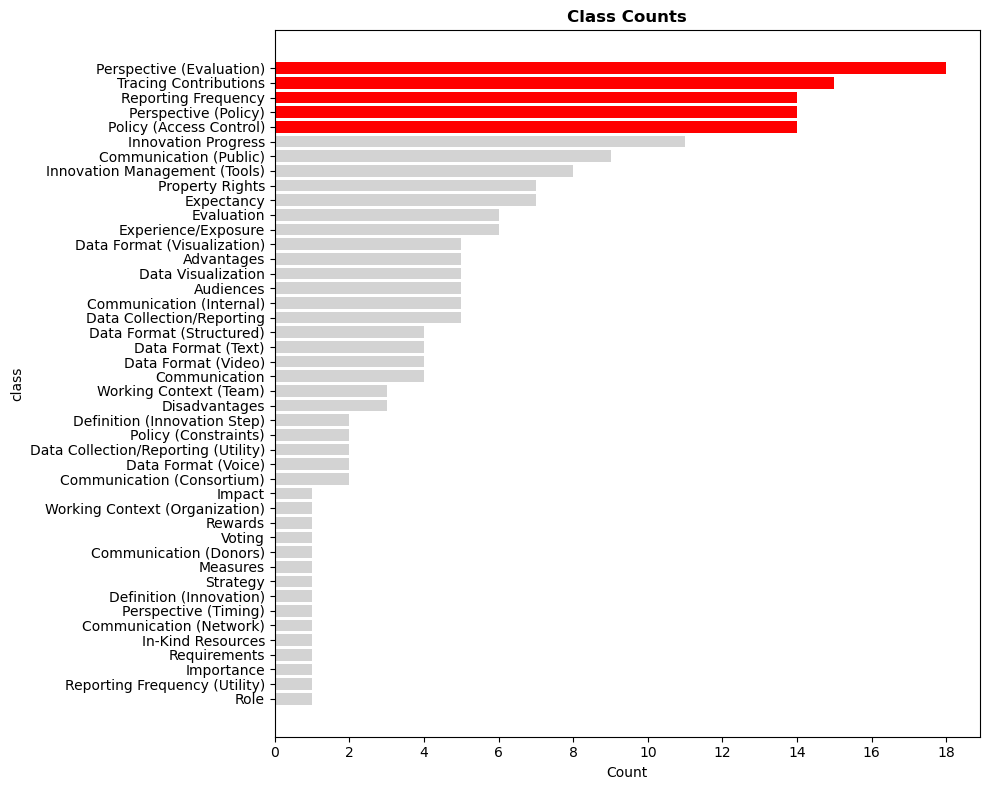

In [592]:
from matplotlib.ticker import MaxNLocator



# sort by count
cc = class_counts.sort_values('count')

# colors: top 5 red, rest grey
colors = ['red' if i >= len(cc) - 5 else 'lightgrey' for i in range(len(wc))]

plt.figure(figsize=(10, 8))
plt.barh(cc['class'], cc['count'], color=colors, height=0.8)
plt.ylabel('class')
plt.xlabel('Count')
plt.title('Class Counts', fontweight = 'bold')

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()

plt.savefig(
    './figures/Class_Counts_Deductive.png', 
    format='png', 
    dpi=300,
    bbox_inches="tight")

plt.show()


In [179]:
q_to_classes = (
    df.set_index('QID')['Classes']
      .str.split(',')
      .apply(lambda x: [c.strip() for c in x])
      .to_dict()
)

In [180]:
df

Thematic    QID                                           Question  \
0         Y    Q:1                     Which is your role in Cogitor?   
1         N    Q:2  Have you been exposed to the use of models to ...   
2         Y    Q:3  Exposure to methods for evaluating innovation ...   
3         Y  Q:3:a  Could you describe in which context and mentio...   
4         Y  Q:3:b  Which indicators were adopted to measure innov...   
..      ...    ...                                                ...   
74        Y   Q:31   Which ideas should NOT be disclosed to partners?   
75        Y   Q:32  Which information could be communicated to pub...   
76        Y   Q:33  Which information should be communicated to pr...   
77        Y   Q:34  Advantages and disadvantages of tracing and co...   
78        Y   Q:35  What kind of results should tracing innovation...   

                                              Classes     \
0                role, working context (organization)      
1   experience/exposure, innovation management (to...      
2   experience/exposure, innovation management (to...      
3         working context (team), experience/exposure      
4           measures, innovation progress, evaluation      
..                                                ... ..   
74  policy (constraints), perspective (policy), po...      
75  communication (public), policy (constraints), ...      
76  communication (public), perspective (policy), ...      
77  advantages, disadvantages, tracing contributio...      
78  expectancy, tracing contributions, innovation ...      

                           Macro-Area  \
0                    Role and Context   
1                         Definitions   
2   Practice for measuring innovation   
3      Tools for measuring innovation   
4         Communication of innovation   
..                                ...   
74                                      
75                                      
76                                      
77                                      
78                                      

                                Descriptors (Classes)  
0   role, working context (team), working context ...  
1   definition (innovation), definition (innovatio...  
2   innovation progress, measures, evaluation, dat...  
3   innovation management (tools), data visualizat...  
4   communication, communication (internal), commu...  
..                                                ...  
74                                                     
75                                                     
76                                                     
77                                                     
78                                                     

[79 rows x 7 columns]

In [181]:
# exclude questions from thematic analysis

exclude_qid = df[df['Thematic'] == 'N']['QID'].values.tolist()

# Network analysis

- Use themes that emerge inductively through coding, or:
- Assign theme labels based on community detection applied to the projected graph of codes (i.e. the bipartite graph of sentences and codes projected onto a code-to-code graph).


## Load data

In [249]:
# Test for one respondent

work_sheet = sheet.worksheet("Respondent R4")

In [285]:
import pandas as pd

headers = [ 'ID', 'QID', 'QID_', 'Sentence', 'Codes', 'Themes']

df = pd.DataFrame(work_sheet.get_all_records(expected_headers=headers))

In [295]:
def filter_valid_rows(df):
    return df[

        # Select desired criterias:

        # Import the rows that have the ID of the Row, and the ID of the Sub_Question
        df["ID"].notna() &
        df["QID_"].notna() &
        (df["QID"].isna() | (df["QID"].astype(str).str.strip() == "")) &

        ## But the Codes are not empty
        df["Codes"].notna() &
        (df["Codes"].astype(str).str.strip() != "") &

        ## and restrict to open questions only
        (df["QID_"].isin(exclude_qid).apply(lambda x : not(x)))
    ]

In [296]:
df = filter_valid_rows(df)

In [297]:
# this to normalise the QID_ in Respondent sheets
# in the master sheet I used Q:ID:sub, in Respondent sheets Q:IDsub

import re
def normalize_qid(qid):
    return re.sub(r'(Q:\d+)([a-zA-Z])', r'\1:\2', qid)

df['QID_'] = df['QID_'].apply(normalize_qid)

## Create the multi-partite graph (Sentence-Code-Theme)

In [298]:
#initialize graph
import igraph as ig

g = ig.Graph(directed=False)

In [299]:
g.vcount()

0

In [300]:
node_index = {}

In [301]:
def add_sentence_nodes(g, df_valid, node_index, use_qid = True):
    for _, row in df_valid.iterrows():

        if use_qid:
            node_id = f"{row['ID']}-{row['QID_']}"
        else:
            node_id = f"{row['ID']}"

        if node_id not in node_index:
            g.add_vertex(
                name=node_id,
                node_id=node_id,
                text=row["Sentence"],
                type="Sentence"
            )
            node_index[node_id] = g.vcount() - 1 

In [302]:
def add_code_nodes(g, df_valid, node_index):
    
    for _, row in df_valid.iterrows():
        codes = row.get("Codes")

        if pd.isna(codes):
            continue

        for code in [c.strip() for c in codes.split(",") if c.strip()]:
            node_id = f"Code:{code}"

            if node_id not in node_index:
                g.add_vertex(
                    name=node_id,
                    text=code,
                    type="Code"
                )
                node_index[node_id] = g.vcount() - 1


In [303]:
def add_theme_nodes(g, df_valid, node_index):
    for _, row in df_valid.iterrows():
        themes = row.get("Themes")

        if pd.isna(themes):
            continue

        for theme in [t.strip() for t in themes.split(",") if t.strip()]:
            node_id = f"Theme:{theme}"

            if node_id not in node_index:
                g.add_vertex(
                    name=node_id,
                    text=theme,
                    type="Theme"
                )
                node_index[node_id] = g.vcount() - 1


In [304]:
add_sentence_nodes(g, df, node_index)

In [305]:
add_code_nodes(g, df, node_index)

In [306]:
add_theme_nodes(g, df, node_index)

In [307]:
g.vcount()

147

In [308]:
def add_edges(g, df_valid, node_index, use_qid = True):
    for _, row in df_valid.iterrows():
        
        if use_qid:
            sentence_id = f"{row['ID']}-{row['QID_']}"
        else:
            sentence_id = f"{row['ID']}"
            
        sentence_idx = node_index.get(sentence_id)

        if sentence_idx is None:
            continue

        # ---- Sentence → Code ----
        codes = row.get("Codes")
        code_ids = []

        if pd.notna(codes):
            code_list = [c.strip() for c in codes.split(",") if c.strip()]
            for code in code_list:
                code_node_id = f"Code:{code}"
                code_idx = node_index.get(code_node_id)
                if code_idx is not None:
                    g.add_edge(sentence_idx, code_idx)
                    code_ids.append(code_node_id)

        # ---- Code → Theme ----
        themes = row.get("Themes")
        if pd.notna(themes):
            theme_list = [t.strip() for t in themes.split(",") if t.strip()]
            for theme in theme_list:
                theme_node_id = f"Theme:{theme}"
                theme_idx = node_index.get(theme_node_id)

                if theme_idx is not None:
                    for code_node_id in code_ids:
                        code_idx = node_index[code_node_id]
                        g.add_edge(code_idx, theme_idx)


In [309]:
add_edges(g, df, node_index)

In [246]:
def add_class_edges(g, df_valid, node_index, q_to_classes):
    for _, row in df_valid.iterrows():
        sentence_id = f"{row['ID']}-{row['QID_']}"
        sentence_idx = node_index.get(sentence_id)
        qid = row['QID_']

        if sentence_idx is None or qid not in q_to_classes:
            continue

        classes = q_to_classes[qid]
        for cls in classes:
            class_node_id = f"Class:{cls}"
            if class_node_id not in node_index:
                g.add_vertex(
                    name=class_node_id,
                    text=cls,
                    type="Class"
                )
                node_index[class_node_id] = g.vcount() - 1

            class_idx = node_index[class_node_id]
            g.add_edge(sentence_idx, class_idx)


In [247]:
add_class_edges(g, df, node_index, q_to_classes)

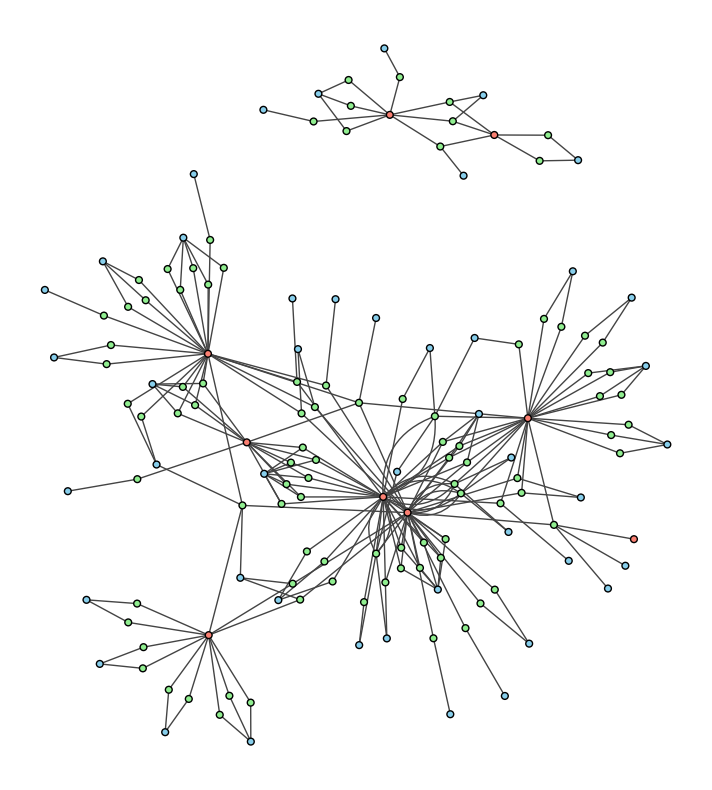

In [317]:
import matplotlib.pyplot as plt
import igraph as ig

def plot_whole_graph(g, save = False):
    
    layout = g.layout("fr")
    
    color_map = {
        "Sentence": "skyblue",
        "Code": "lightgreen",
        "Theme": "salmon"
    }
    
    g.vs["color"] = [color_map.get(t, "gray") for t in g.vs["type"]]
    g.vs["label"] = g.vs["text"]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    ig.plot(
        g,
        target=ax,
        layout=layout,
        vertex_size=.2,
        edge_width=1,
        vertex_label=None
    )
    
    plt.axis("off")
    plt.show()


plot_whole_graph(g)

In [88]:
#!pip uninstall -y matplotlib matplotlib-inline ipython
#!pip install matplotlib==3.6.0 matplotlib-inline==0.1.3 ipython==8.18.1

In [326]:
g.vs[0]

igraph.Vertex(<igraph.Graph object at 0x129fef150>, 0, {'node_id': 'R4:2-Q:1', 'text': 'I am involved in the final phase of the project, where I assist Prof. [X] in assembling the final prototype. ', 'type': 'Sentence', 'name': 'R4:2-Q:1', 'color': 'skyblue', 'label': 'I am involved in the final phase of the project, where I assist Prof. [X] in assembling the final prototype. '})

In [311]:
# Test

disconnected_sentences = []

for v in g.vs:
    if v["type"] == "Sentence" and g.degree(v.index) == 0:
        disconnected_sentences.append({
            "ID": v["name"],
            "Text": v["text"]
        })

# If you want to see them in a DataFrame:
import pandas as pd
df_disconnected = pd.DataFrame(disconnected_sentences)

# Print or display
print(df_disconnected)


Empty DataFrame
Columns: []
Index: []


## Assisting assignment of Themes (Community on Code-Code graph)

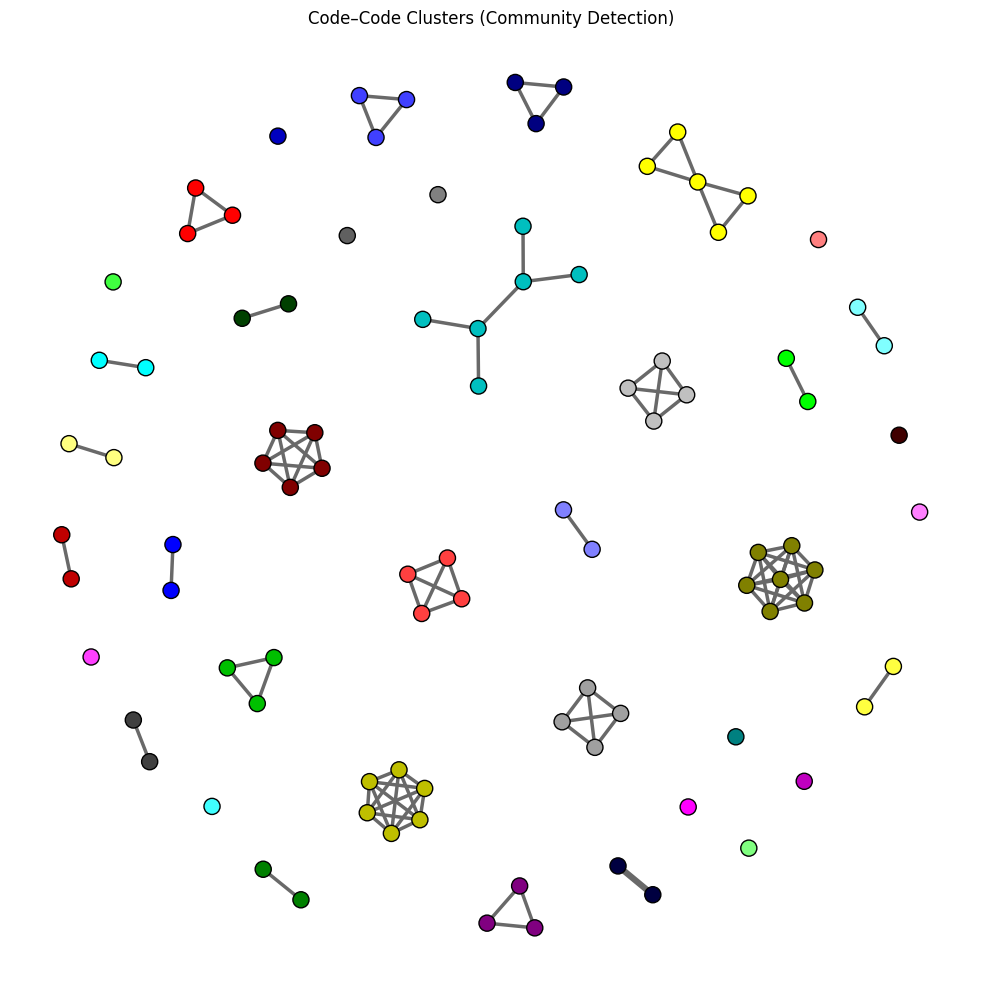

In [312]:
import igraph as ig
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

# 1. FILTER Sentence–Code edges
sentence_nodes = [v.index for v in g.vs if v["type"] == "Sentence"]
code_nodes = [v.index for v in g.vs if v["type"] == "Code"]

# Build bipartite graph edges
bipartite_edges = []
for e in g.es:
    src, tgt = e.source, e.target
    if (src in sentence_nodes and tgt in code_nodes) or (src in code_nodes and tgt in sentence_nodes):
        bipartite_edges.append((src, tgt))

# 2. Project Code–Code network from bipartite edges
# Map: Sentence -> list of Codes
sentence_to_codes = defaultdict(set)

for src, tgt in bipartite_edges:
    if g.vs[src]["type"] == "Sentence":
        sentence = src
        code = tgt
    else:
        sentence = tgt
        code = src
    sentence_to_codes[sentence].add(code)

# Create Code–Code edges (co-occurrence in same sentence)
code_code_edges = defaultdict(int)

for codes in sentence_to_codes.values():
    codes = list(codes)
    for i in range(len(codes)):
        for j in range(i + 1, len(codes)):
            pair = tuple(sorted((codes[i], codes[j])))
            code_code_edges[pair] += 1

# 3. Build the Code–Code network
code_graph = ig.Graph()
code_id_to_idx = {}
for idx in code_nodes:
    v = g.vs[idx]
    new_idx = code_graph.vcount()
    code_graph.add_vertex(name=v["name"], text=v["text"])
    code_id_to_idx[idx] = new_idx

# Add edges
for (i, j), weight in code_code_edges.items():
    code_graph.add_edge(code_id_to_idx[i], code_id_to_idx[j], weight=weight)

# 4. Run community detection
clusters = code_graph.community_multilevel(weights="weight")
membership = clusters.membership

# Assign cluster ID as a new vertex attribute
code_graph.vs["cluster"] = membership

# 5. Plot clusters
layout = code_graph.layout("fr")
fig, ax = plt.subplots(figsize=(12, 10))
ig.plot(
    clusters,
    layout=layout,
    #vertex_label=code_graph.vs["text"],
    vertex_label=None,
    target=ax,
    vertex_size=0.3,
    edge_width=[0.5 + 2 * w for w in code_graph.es["weight"]],
    bbox=(800, 800)
)
plt.title("Code–Code Clusters (Community Detection)")
plt.tight_layout()
plt.show()

# 6. Export sample codes per cluster
cluster_to_codes = defaultdict(list)

for v in code_graph.vs:
    cluster_id = v["cluster"]
    cluster_to_codes[cluster_id].append(v["text"])

# Create DataFrame of samples
cluster_samples = [
    {"Cluster": k, "Sample Codes": ", ".join(v[:5])}  # first 5 codes per cluster
    for k, v in cluster_to_codes.items()
]
df_clusters = pd.DataFrame(cluster_samples)

# Display or export
#import caas_jupyter_tools
#caas_jupyter_tools.display_dataframe_to_user(name="Code Clusters (Top 5 Samples)", dataframe=df_clusters)


In [313]:
# --- 7. Keep only largest connected component ---
components = code_graph.components()
giant = components.giant()

# Re-run community detection on the giant component
giant_clusters = giant.community_multilevel(weights="weight")
giant.vs["cluster"] = giant_clusters.membership

In [314]:
# --- 8. Betweenness centrality ---
bet = giant.betweenness(weights="weight", directed=False)
giant.vs["betweenness"] = bet

# Label only top X% nodes by betweenness
PERCENTILE = 0.95  # top 10%
threshold = sorted(bet)[int(len(bet) * PERCENTILE)]

labels = [
    v["text"] if v["betweenness"] >= threshold else ""
    for v in giant.vs
]

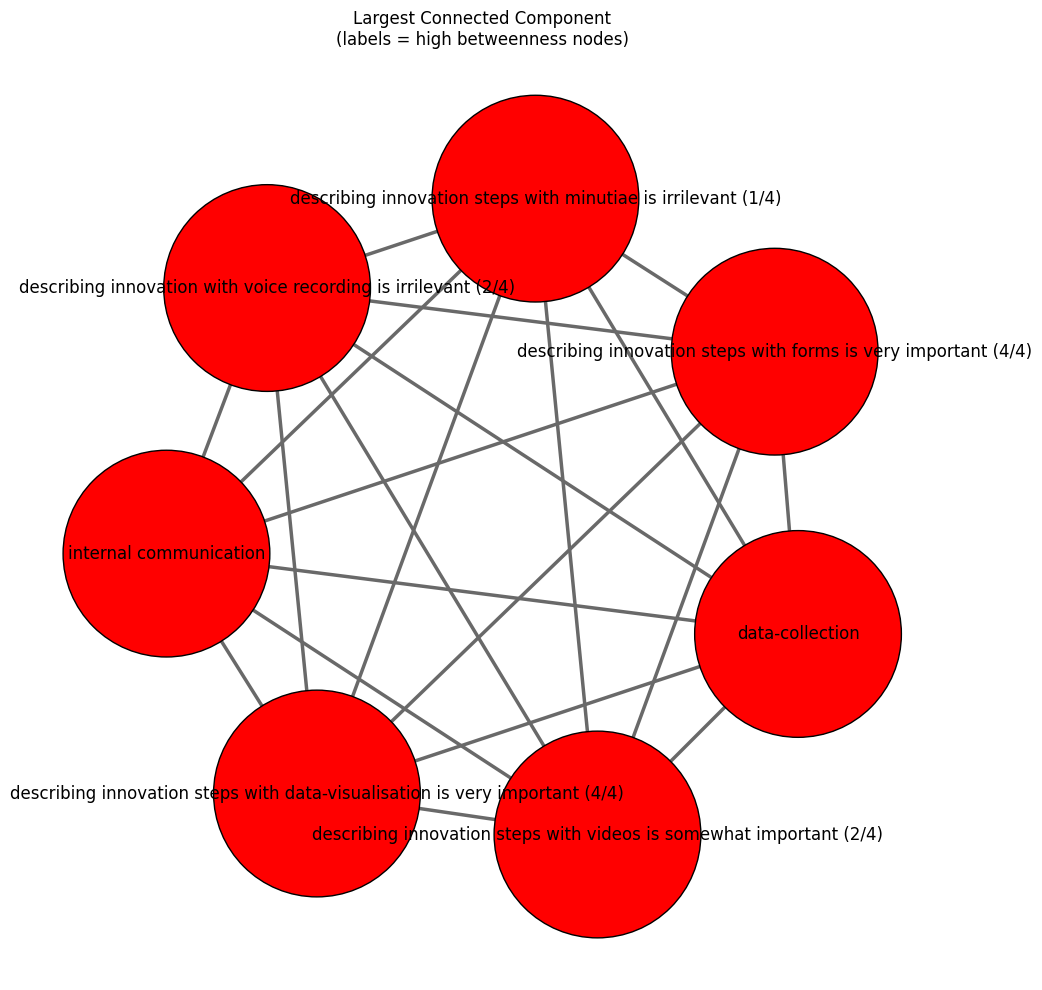

In [315]:
layout = giant.layout("fr")
fig, ax = plt.subplots(figsize=(12, 10))

ig.plot(
    giant_clusters,
    layout=layout,
    vertex_label=labels,
    target=ax,
    vertex_size=0.4,
    edge_width=[0.5 + 2 * w for w in giant.es["weight"]],
    bbox=(800, 800)
)

plt.title("Largest Connected Component\n(labels = high betweenness nodes)")
plt.tight_layout()
plt.show()

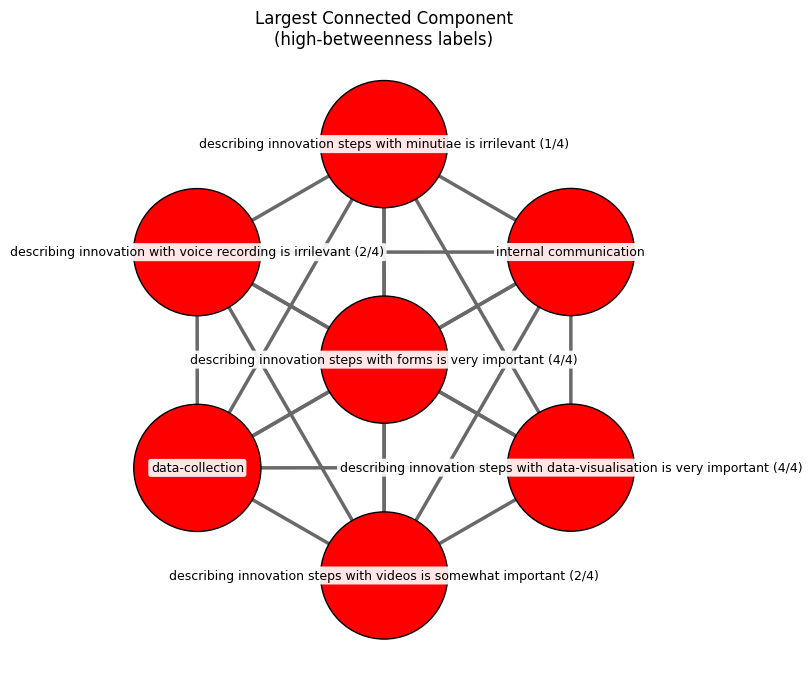

In [316]:
layout = giant.layout("fr")
coords = layout.coords

fig, ax = plt.subplots(figsize=(8, 10))

ig.plot(
    giant_clusters,
    layout=layout,
    vertex_label=None,   # IMPORTANT
    target=ax,
    vertex_size=0.4,
    edge_width=[0.5 + 2 * w for w in giant.es["weight"]],
    bbox=(800, 800)
)

for (x, y), v in zip(coords, giant.vs):
    if v["betweenness"] >= threshold:
        ax.text(
            x, y,
            v["text"],
            fontsize=9,
            ha="center",
            va="center",
            bbox=dict(
                facecolor="white",
                edgecolor="none",
                alpha=0.90,
                boxstyle="round,pad=0.2"
            )
        )

plt.title("Largest Connected Component\n(high-betweenness labels)")
plt.tight_layout()
plt.show()

## Report

### Centrality of Codes

In [318]:
import pandas as pd

def code_centrality_report(g, top_n=30, use_weights=False, weight_attr="weight"):
    # Select only "Code" nodes
    code_vids = [v.index for v in g.vs if v["type"] == "Code"]

    # Compute betweenness centrality
    if use_weights and weight_attr in g.es.attributes():
        btw = g.betweenness(vertices=code_vids, weights=g.es[weight_attr])
    else:
        btw = g.betweenness(vertices=code_vids)

    rows = []
    for i, vid in enumerate(code_vids):
        v = g.vs[vid]
        neigh = g.neighbors(vid)

        n_sent = sum(g.vs[n]["type"] == "Sentence" for n in neigh)
        n_theme = sum(g.vs[n]["type"] == "Theme" for n in neigh)

        rows.append({
            "code_name": v["name"],
            "code_text": v["text"] if "text" in v.attributes() else v["name"],
            "degree_total": g.degree(vid),
            "n_sentences_linked": n_sent,
            "n_themes_linked": n_theme,
            "betweenness": btw[i],
        })

    df = pd.DataFrame(rows).sort_values(
        ["n_sentences_linked", "betweenness", "n_themes_linked"],
        ascending=[False, False, False]
    )

    return df.head(top_n), df

In [319]:
top, full = code_centrality_report(g, top_n=20)
top.head()

code_name  \
30                            Code:valuing authorship   
28                                Code:accountability   
9                      Code:visualisation of pathways   
71  Code:Voting on innovation steps encourages eng...   
91                     Code:meta-research opportunity   

                                            code_text  degree_total  \
30                                 valuing authorship             7   
28                                     accountability             6   
9                           visualisation of pathways             5   
71  Voting on innovation steps encourages engageme...             5   
91                          meta-research opportunity             7   

    n_sentences_linked  n_themes_linked  betweenness  
30                   3                4   357.003995  
28                   3                3   321.958259  
9                    2                3  1137.953903  
71                   2                3   432.547220  
91                   2                5   428.057730

### Recall of Sentences (sentences supporting a Code or a Theme)

In [320]:
def get_sentences_linked_to_node(g, node_name):
    # Find the node by name
    try:
        node = g.vs.find(name=node_name)
    except ValueError:
        print(f"Node '{node_name}' not found in the graph.")
        return []

    # Get neighbors that are Sentence nodes
    neighbors = g.neighbors(node.index)
    sentence_nodes = [
        g.vs[n] for n in neighbors
        if g.vs[n]["type"] == "Sentence"
    ]

    # Return as list of (ID, Text)
    return [
        {"sentence_id": s["name"], "sentence_text": s["text"]}
        for s in sentence_nodes
    ]

In [321]:
get_sentences_linked_to_node(g, 'Code:traceability benefits')

Node 'Code:traceability benefits' not found in the graph.


[]

In [367]:
def subgraph_between_themes(g, theme_a, theme_b, types_to_keep=None):
    # Trova i due vertici Theme (per name o per text: qui assumo name)
    va = g.vs.find(name=theme_a)
    vb = g.vs.find(name=theme_b)

    if va["type"] != "Theme" or vb["type"] != "Theme":
        raise ValueError("theme_a e theme_b devono essere nodi di type='Theme' (name=...).")

    # Tutti i shortest paths (possono essercene molte)
    paths = g.get_all_shortest_paths(va.index, to=vb.index)

    keep = set()
    for p in paths:
        keep.update(p)

    # Opzionale: filtro per tipo
    if types_to_keep is not None:
        types_to_keep = set(types_to_keep)
        keep_filtered = set()
        for vid in keep:
            if g.vs[vid]["type"] in types_to_keep:
                keep_filtered.add(vid)

        # preserva i due temi sempre
        keep_filtered.add(va.index)
        keep_filtered.add(vb.index)
        keep = keep_filtered

    sg = g.induced_subgraph(sorted(keep))
    return sg

In [363]:
g.vs[0]["type"]

'Sentence'

In [361]:
sg_all = subgraph_between_themes(g, "Theme:opportunity", "Theme:perception", types_to_keep=None)

In [425]:
sg_tc  = subgraph_between_themes(g, "Theme:opportunity", "Theme:perception", types_to_keep=["Sentence", "Code"])



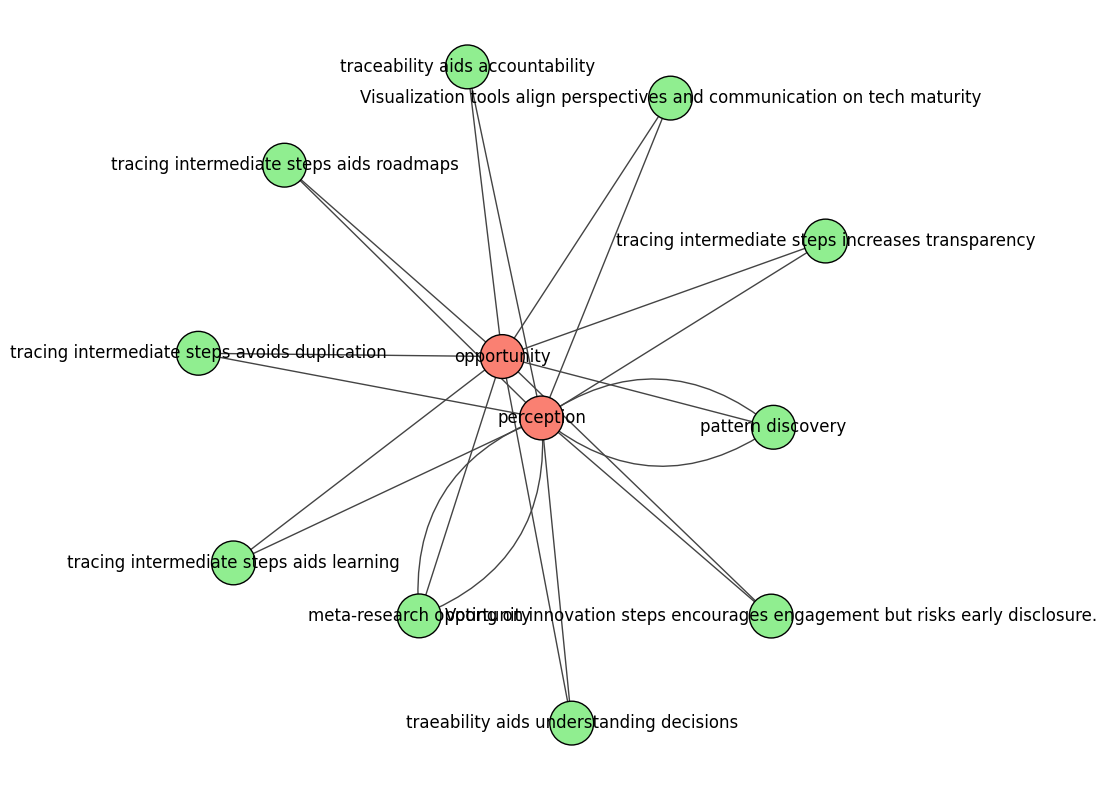

In [426]:
fig, ax = plt.subplots(figsize=(10, 10))

ig.plot(
    sg_tc,
    target=ax,
    layout=sg_tc.layout('fr'),
    vertex_size=0.2,
    edge_width=1,
    #vertex_label=None
)

plt.show()

In [356]:
# Keep only largest connected component ---
components = sg_tc.components()
giant = components.giant()

# Re-run community detection on the giant component
giant_clusters = giant.community_multilevel()
giant.vs["cluster"] = giant_clusters.membership

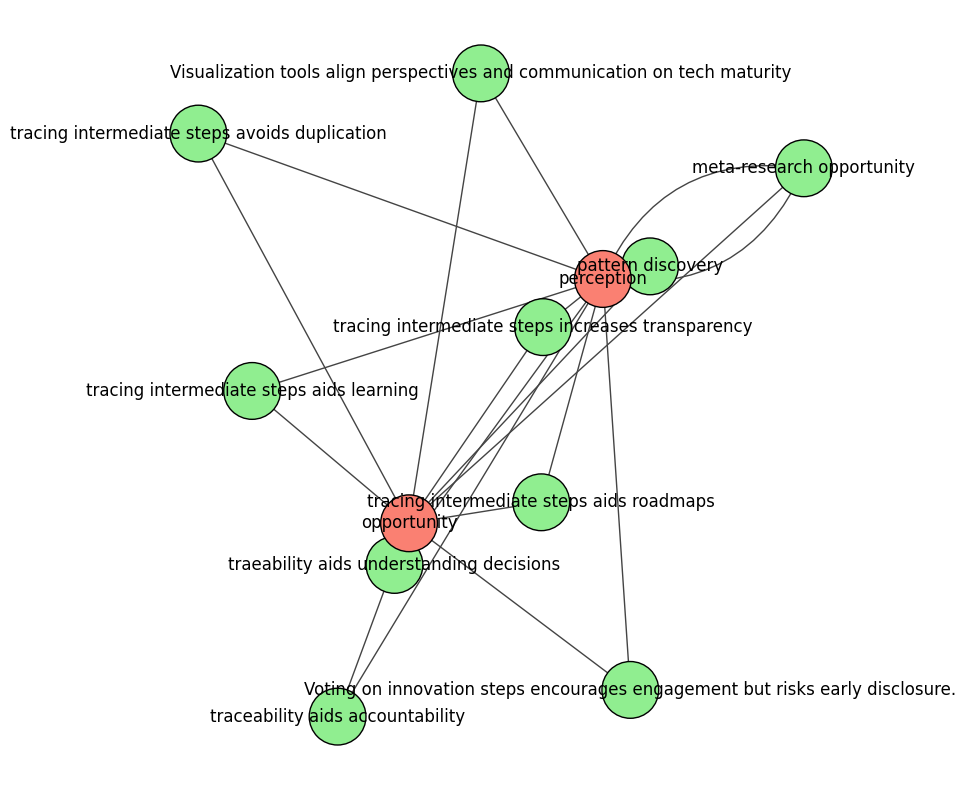

In [358]:
fig, ax = plt.subplots(figsize=(10, 10))

ig.plot(
    sg_all,
    target=ax,
    vertex_size=0.2,
    edge_width=1,
    layout = sg_all.layout_umap()
    #vertex_label=None
)

plt.show()

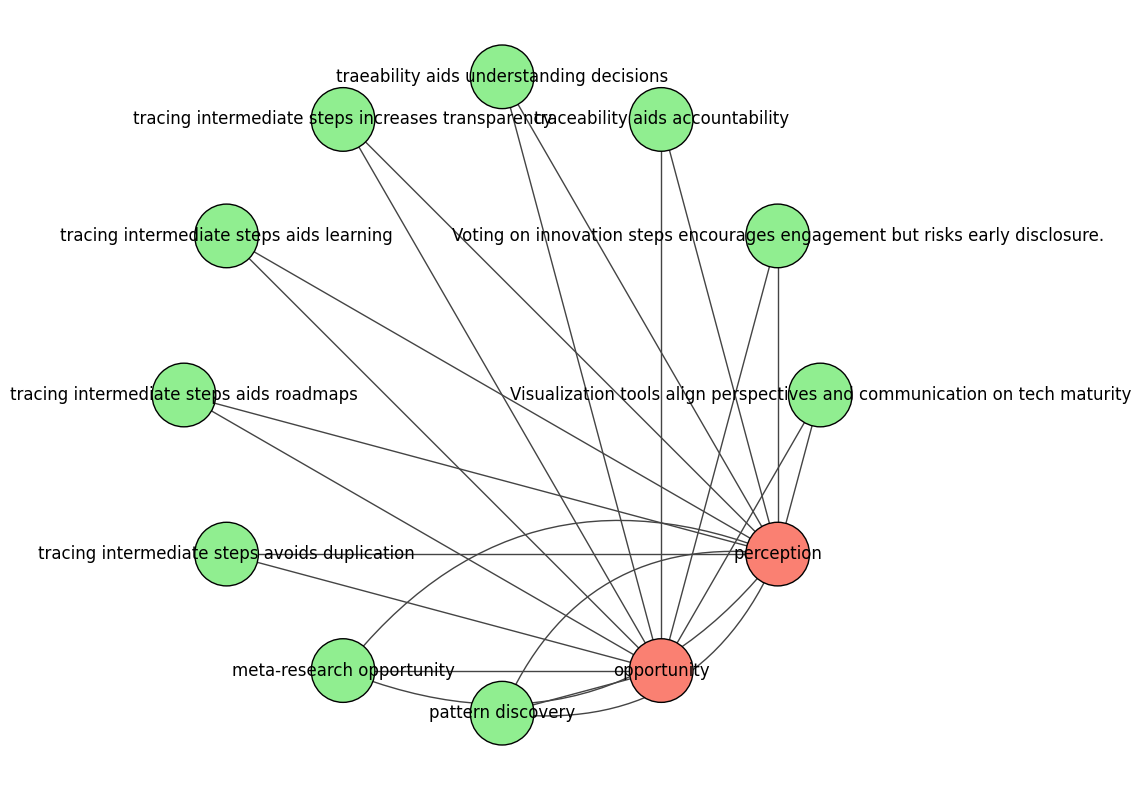

In [387]:
fig, ax = plt.subplots(figsize=(10, 10))

ig.plot(
    sg_tc,
    target=ax,
    layout=sg_tc.layout('circle'),
    vertex_size=.2,
    edge_width=1,
    #vertex_label=None
)

plt.show()

In [392]:
# Recall sentences for a Theme

def sentences_for_theme(g, theme_name, exclusive=False):
    t = g.vs.find(name=theme_name)
    if t["type"] != "Theme":
        raise ValueError("theme_name deve essere un nodo di type='Theme' (name=...).")

    # code vicini del tema
    code_vids = [n for n in g.neighbors(t.index) if g.vs[n]["type"] == "Code"]

    # frasi vicine di quei code
    sentence_vids = set()
    for c in code_vids:
        for n in g.neighbors(c):
            if g.vs[n]["type"] == "Sentence":
                sentence_vids.add(n)

    if not exclusive:
        # ritorna tutte
        return [g.vs[s]["text"] for s in sorted(sentence_vids)]

    # exclusive=True: tieni solo frasi che NON arrivano ad altri temi
    exclusive_sentences = []
    for s in sentence_vids:
        # temi raggiungibili in 2 hop: Sentence -> Code -> Theme
        themes_reached = set()
        for c in g.neighbors(s):
            if g.vs[c]["type"] != "Code":
                continue
            for tt in g.neighbors(c):
                if g.vs[tt]["type"] == "Theme":
                    themes_reached.add(g.vs[tt]["name"])

        if themes_reached == {theme_name}:
            exclusive_sentences.append(g.vs[s]["text"])

    return exclusive_sentences


In [393]:
sent_all = sentences_for_theme(g, "Theme:opportunity", exclusive=False)
sent_only = sentences_for_theme(g, "Theme:opportunity", exclusive=True)

In [396]:
sent_all

['Alongside this, I am also developing exploratory work on unconventional computing using ferrofluid systems.',
 'Tracing small steps ensures contributions are recognized, supports collaboration, avoids duplicated work, and provides documentation useful for publications or patents. ',
 'Even small innovations arising from practical needs can lead to major scientific or economic impacts. ',
 'Public communication increases transparency, can attract collaboration or funding, and inspires younger generations to engage with science.',
 'I believe these tools are very important because if a team does not share the same “language” or understanding of the project status, its progress, roles, and timeline, then team members cannot properly understand each other or coordinate effectively.',
 'It would help identify bottlenecks, reveal new opportunities, stimulate collaboration, and strengthen motivation by making contributions visible.',
 'Advantages: control, quality assurance, and avoiding in

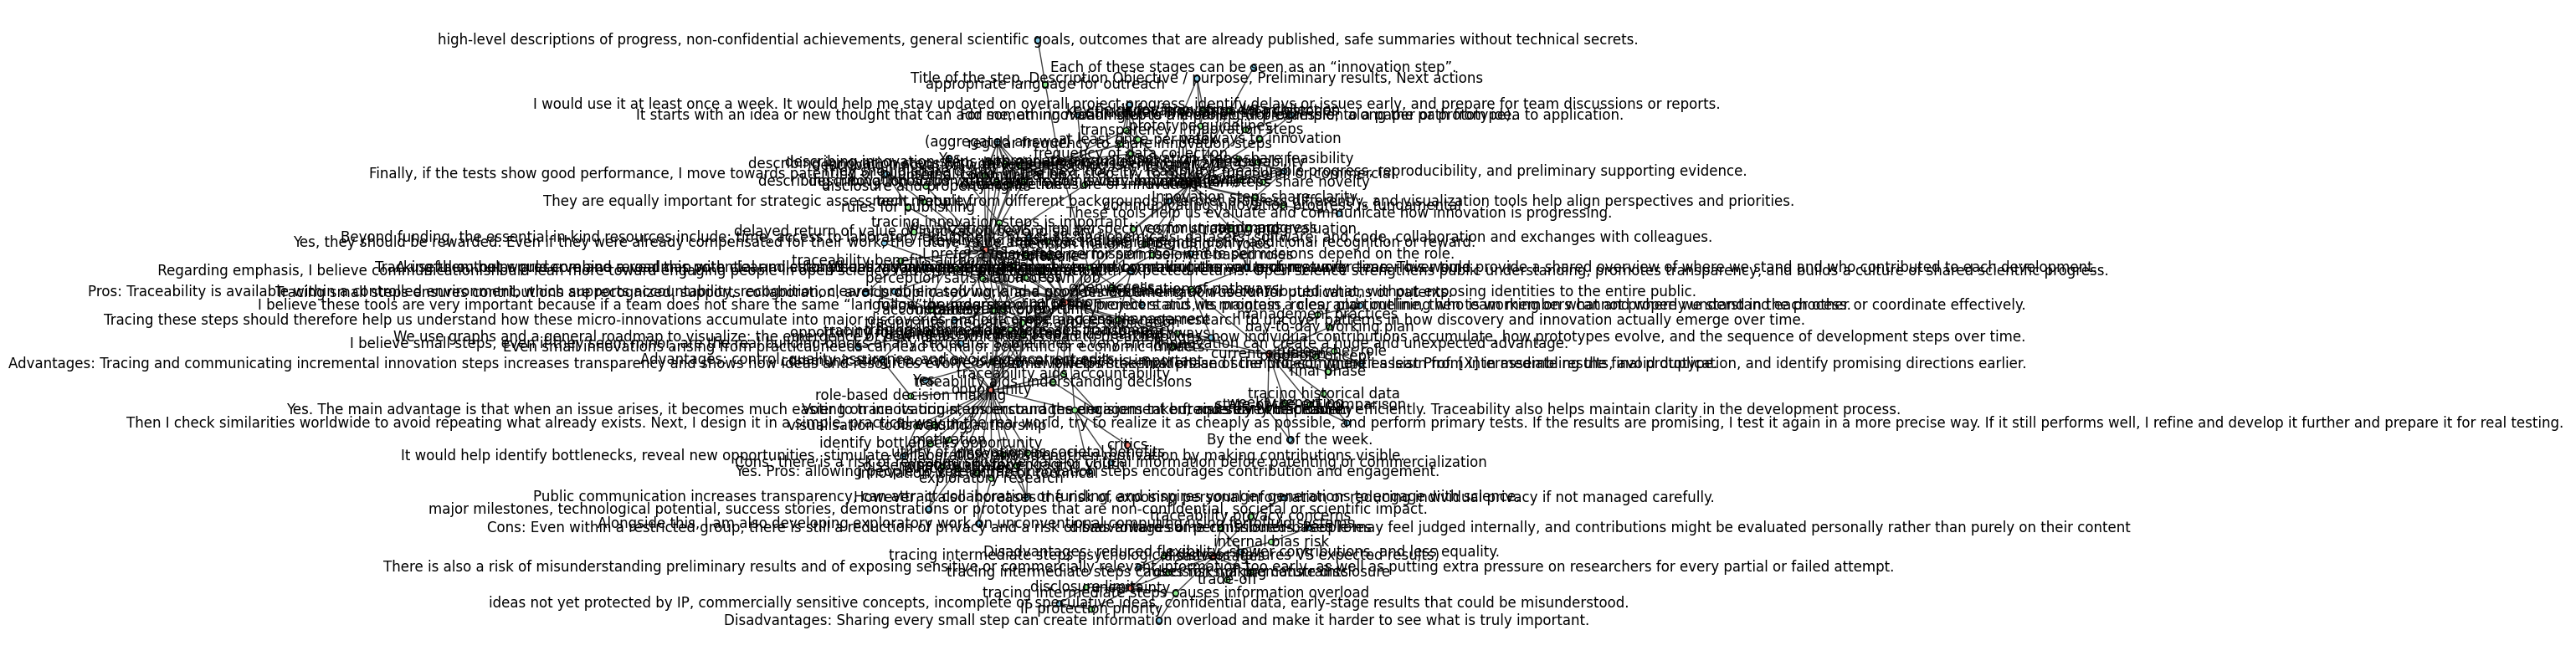

In [399]:
fig, ax = plt.subplots(figsize=(10, 10))

ig.plot(
    g,
    target=ax,
    layout=g.layout('fr'),
    vertex_size=0.2,
    edge_width=1,
    #vertex_label=None
)

plt.show()

### Community detections (group of codes covering a theme)

In [400]:
def detect_communities(g, method="leiden", resolution=1.0, add_membership_attr=True):
    method = method.lower()

    if method == "leiden":
        # python-igraph recenti: community_leiden
        if hasattr(g, "community_leiden"):
            part = g.community_leiden(objective_function="modularity", resolution_parameter=resolution)
        else:
            # fallback
            part = g.community_multilevel()

    elif method in ("louvain", "multilevel"):
        part = g.community_multilevel()

    elif method == "infomap":
        part = g.community_infomap()

    elif method == "walktrap":
        part = g.community_walktrap().as_clustering()

    elif method in ("labelprop", "label_propagation"):
        part = g.community_label_propagation()

    else:
        raise ValueError("Unknown method. Available methods: leiden, multilevel, infomap, walktrap, label_propagation")

    if add_membership_attr:
        g.vs["community"] = part.membership

    return part


In [401]:
part = detect_communities(g, method="leiden", resolution=1.0)
len(part), part.modularity

(9, 0.6518093348450491)

In [457]:
part.subgraph(cid)

In [467]:
# largest community
cid = max(
    range(len(part)),
    key=lambda c: part.size(c)
)

verts = part.subgraph(cid).vs.indices
subg = g.subgraph(verts)

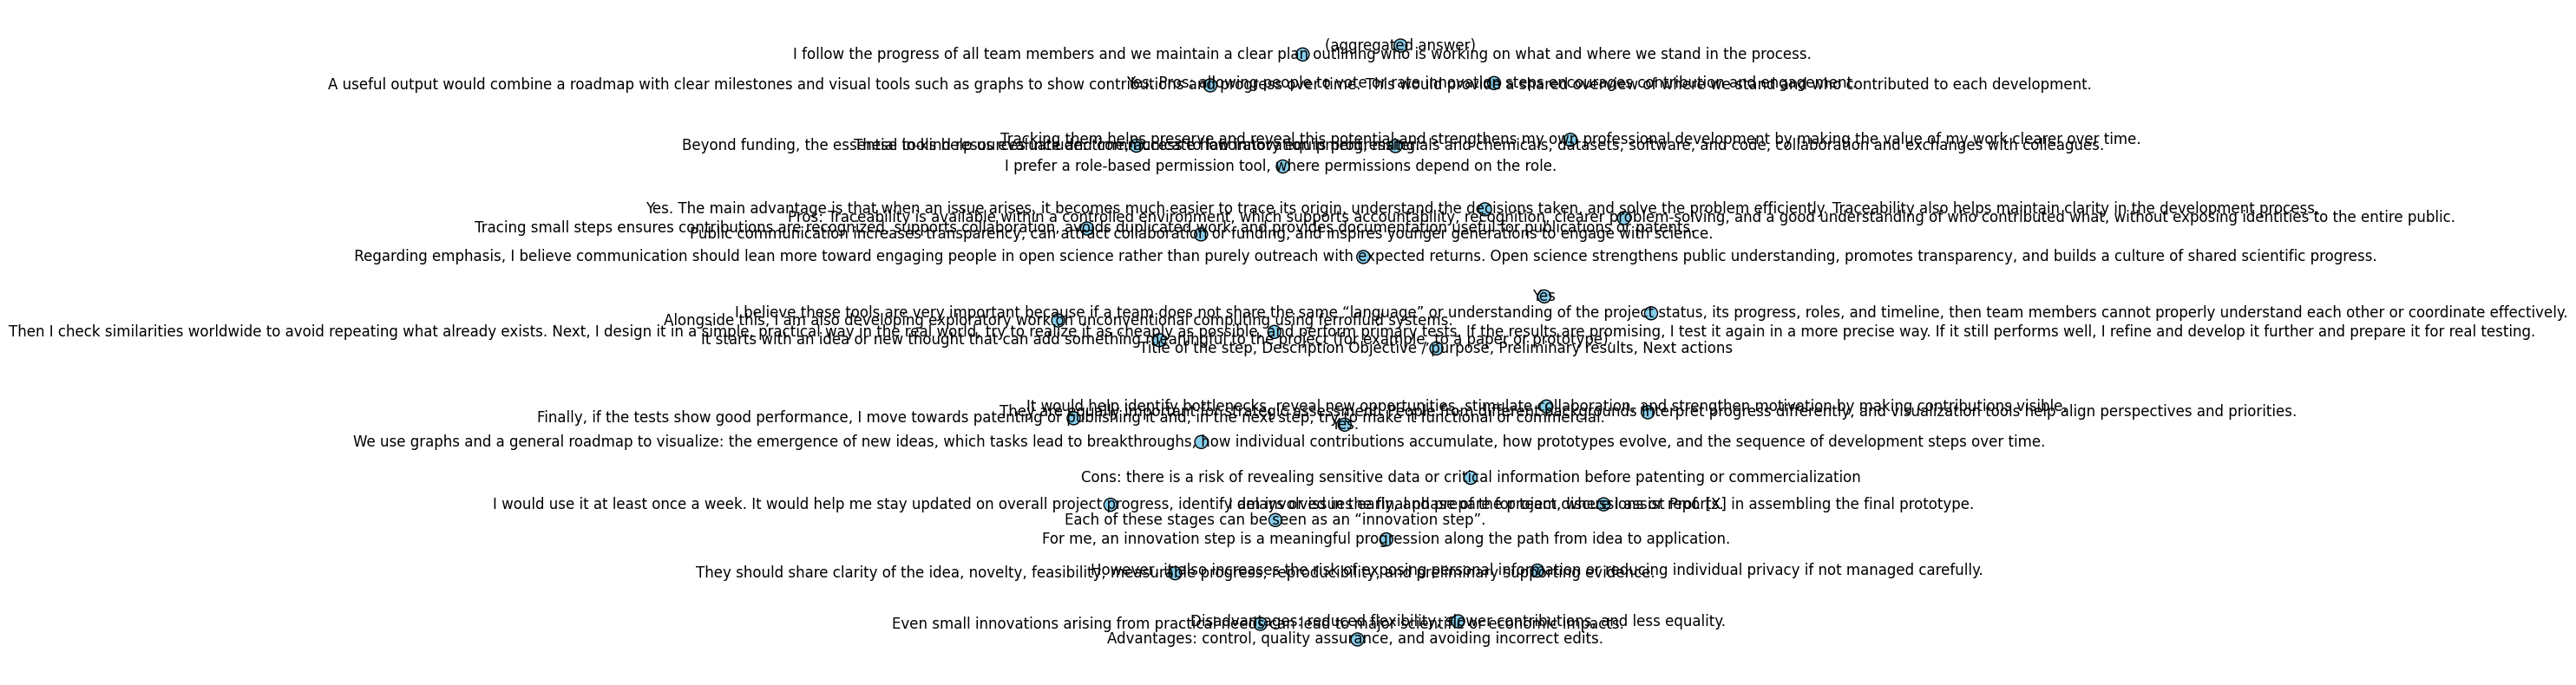

In [468]:
fig, ax = plt.subplots(figsize=(10, 10))

ig.plot(
    subg,
    target=ax,
    layout= subg.layout("fr"),
    vertex_size=0.2,
    edge_width=1,
    #vertex_label=labels,
    #vertex_color=colors
)

plt.show()

In [503]:
k = 20

community_graph = part.subgraph(cid)

top = sorted(
    range(community_graph.vcount()),
    key=lambda i: community_graph.degree(i),
    reverse=True
)[:k]

labels = [None] * community_graph.vcount()
for i in top:
    labels[i] = community_graph.vs[i]["name"]

community_graph.vs["label"] = None

In [504]:
len(labels) != community_graph.vcount()

False

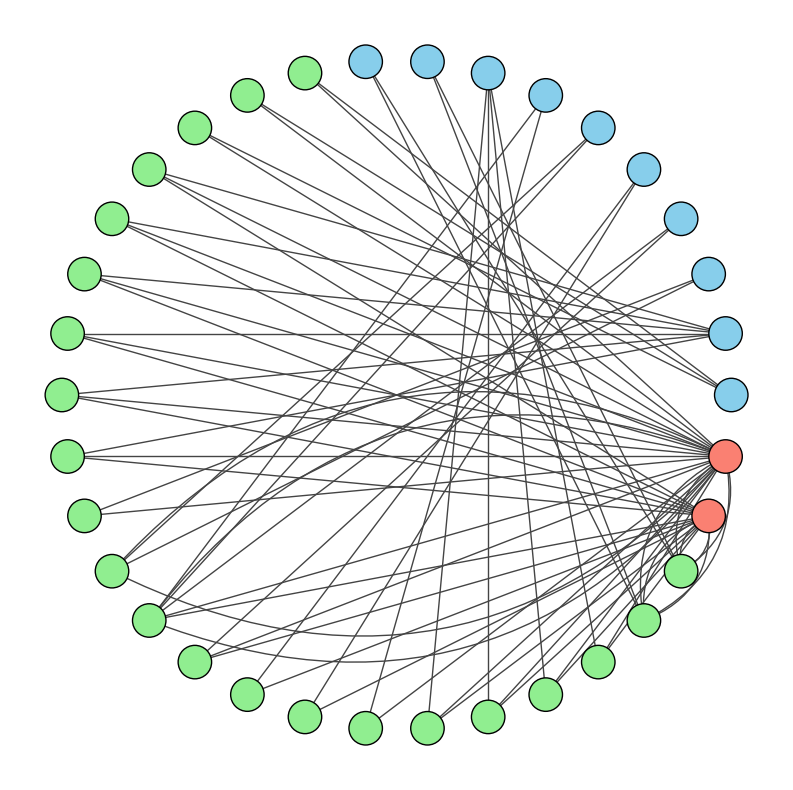

In [507]:
fig, ax = plt.subplots(figsize=(10, 10))

ig.plot(
    community_graph,
    layout=community_graph.layout('circle'),
    target=ax,
    vertex_size=0.1,
    edge_width=1,
    #vertex_label=labels
)

plt.show()

### Most representative sentences (examplars)

In [477]:
from collections import defaultdict

def sentence_projection_by_shared_codes(g, min_shared=1):
    # ids frasi
    s_vids = [v.index for v in g.vs if v["type"] == "Sentence"]
    s_set = set(s_vids)

    # per ogni Sentence, set di Code neighbors
    sent2codes = {}
    for s in s_vids:
        codes = {n for n in g.neighbors(s) if g.vs[n]["type"] == "Code"}
        sent2codes[s] = codes

    # inverted index: code -> sentences
    code2sents = defaultdict(list)
    for s, codes in sent2codes.items():
        for c in codes:
            code2sents[c].append(s)

    # conta co-occorrenze
    pair_w = defaultdict(int)
    for c, sents in code2sents.items():
        sents = sorted(set(sents))
        for i in range(len(sents)):
            for j in range(i+1, len(sents)):
                pair_w[(sents[i], sents[j])] += 1

    # crea grafo proiettato
    import igraph as ig

    proj = ig.Graph()
    proj.add_vertices(len(s_vids))
    # mappa: originale vid -> proj vid
    idx = {s_vids[i]: i for i in range(len(s_vids))}
    proj.vs["orig_vid"] = s_vids
    proj.vs["text"] = [g.vs[s]["text"] for s in s_vids]

    edges = []
    weights = []
    for (a, b), w in pair_w.items():
        if w >= min_shared:
            edges.append((idx[a], idx[b]))
            weights.append(w)

    proj.add_edges(edges)
    proj.es["weight"] = weights

    return proj


In [408]:
import numpy as np

def affinity_propagation_exemplars(sentence_proj, preference=None, damping=0.8, max_iter=500):
    from sklearn.cluster import AffinityPropagation

    n = sentence_proj.vcount()
    # Similarity matrix: default 0, weights sugli edge
    S = np.zeros((n, n), dtype=float)
    for e in sentence_proj.es:
        i, j = e.tuple
        w = e["weight"]
        S[i, j] = w
        S[j, i] = w

    # Diagonale: preference
    if preference is None:
        # euristica: mediana dei valori non-zero, oppure 0 se grafo sparso
        nonzero = S[S > 0]
        pref = float(np.median(nonzero)) if nonzero.size else 0.0
    else:
        pref = float(preference)

    np.fill_diagonal(S, pref)

    ap = AffinityPropagation(affinity="precomputed", damping=damping, max_iter=max_iter, random_state=0)
    ap.fit(S)

    exemplar_idx = ap.cluster_centers_indices_
    labels = ap.labels_

    exemplars = []
    if exemplar_idx is not None:
        for ci in exemplar_idx:
            exemplars.append({
                "proj_vid": int(ci),
                "text": sentence_proj.vs[ci]["text"],
                "n_in_cluster": int(np.sum(labels == labels[ci])),
            })

    return exemplars, labels


In [411]:
proj = sentence_projection_by_shared_codes(g, min_shared=2)
exemplars, labels = affinity_propagation_exemplars(proj, preference=None)
exemplars[:10]


[{'proj_vid': 3,
  'text': 'We use graphs and a general roadmap to visualize: the emergence of new ideas, which tasks lead to breakthroughs, how individual contributions accumulate, how prototypes evolve, and the sequence of development steps over time. ',
  'n_in_cluster': 6},
 {'proj_vid': 9,
  'text': 'Each of these stages can be seen as an “innovation step”.',
  'n_in_cluster': 3},
 {'proj_vid': 12,
  'text': 'Tracing small steps ensures contributions are recognized, supports collaboration, avoids duplicated work, and provides documentation useful for publications or patents. ',
  'n_in_cluster': 3},
 {'proj_vid': 13,
  'text': 'Even small innovations arising from practical needs can lead to major scientific or economic impacts. ',
  'n_in_cluster': 3},
 {'proj_vid': 14,
  'text': 'Tracking them helps preserve and reveal this potential and strengthens my own professional development by making the value of my work clearer over time.',
  'n_in_cluster': 6},
 {'proj_vid': 18,
  'text'

# Network analysis (Loop through all Respondents)

Assumption: If the researcher coded inductively through multiple iterations, the sheets must have columns that map the codes between each iteration, to create a dictionary and inspect the graphs depending on desired granularity

## Load data (All Respondents)

In [8]:
import pandas as pd

In [512]:
# Prepare the dictionaries if needed to converge (reduce the Codes)

work_sheet = sheet.worksheet('Total Classes (All)')

df = pd.DataFrame(work_sheet.get_all_records(expected_headers=['First-cycle Codes (key)','Second-cycle Codes (value)', 'Second-cycle Codes (key)','Third-cycle Codes (value)']))

dict_first_second_c = df.set_index('First-cycle Codes (key)')['Second-cycle Codes (value)'].to_dict()
dict_second_third_c = df.set_index('Second-cycle Codes (key)')['Third-cycle Codes (value)'].to_dict()

def map_codes(dictionary, old_code):
    return dictionary[old_code] if old_code in dictionary else old_code


In [513]:
# Let's iterate through the Respondents

In [591]:
respondents = [f'Respondent R{i}' for i in range(0,5)]

In [182]:
# This are the ID of qustions which were NOT open questions => excluded from the analysis
exclude_qid

['Q:2',
 'Q:9',
 'Q:11:c',
 'Q:12',
 'Q:14:b',
 'Q:18',
 'Q:18:a',
 'Q:18:b',
 'Q:18:c',
 'Q:18:d',
 'Q:20',
 'Q:20:a',
 'Q:20:b',
 'Q:20:c',
 'Q:20:d',
 'Q:20:e',
 'Q:21',
 'Q:21:a',
 'Q:21:b',
 'Q:21:c',
 'Q:25',
 'Q:25:a',
 'Q:25:b',
 'Q:25:c',
 'Q:25:d',
 'Q:27',
 'Q:27:a',
 'Q:27:b',
 'Q:27:c',
 'Q:27:d',
 'Q:27:e',
 'Q:29',
 'Q:29:a',
 'Q:29:b',
 'Q:29:c',
 'Q:29:d',
 'Q:29:e',
 'Q:30',
 'Q:30:a',
 'Q:30:b',
 'Q:30:c',
 'Q:30:d']

In [600]:
# I relaxed this because QID are not mapped in interviews
# (In this work, questionnaires were created after the interviews)

def filter_valid_rows(df):
    
    ## If questionnaire, exclude the questions not for thematic analysis
    if 'QID_' in df.columns:
        
        df = df[~df['QID_'].isin(exclude_qid)]
            
    return df[
        
        ## Codes are not empty
        df["Codes"].notna() &
        (df["Codes"].astype(str).str.strip() != "")
    ]

In [601]:
all_dfs = []  # List to collect all dataframes

for r in respondents: 
    work_sheet = sheet.worksheet(r)

    # These are the columns you ultimately want in the merged result
    final_columns = ['ID', 'QID', 'QID_', 'Sentence', 'Codes', 'Themes']
    
    # Try with the common subset of headers (as appears in some worksheets)
    headers = ['ID', 'Sentence', 'Codes', 'Themes']
    df = pd.DataFrame(work_sheet.get_all_records(expected_headers=headers))

    df = filter_valid_rows(df)

    # Ensure missing columns are added as empty strings
    for col in final_columns:
        if col not in df.columns:
            df[col] = ""

    # Reorder columns to ensure consistency
    df = df[final_columns]

    # Add to list
    all_dfs.append(df)

# Merge all collected DataFrames into one
df_merged = pd.concat(all_dfs, ignore_index=True)

In [602]:
df_merged['Codes'] = df_merged['Codes'].str.split(',')
df_merged['Codes'] = df_merged['Codes'].apply(lambda x : {c.strip() for c in x})
df_merged['Codes'] = df_merged['Codes'].apply(set)

df_merged['Themes'] = df_merged['Themes'].str.split(',')
df_merged['Themes'] = df_merged['Themes'].apply(lambda x : {c.strip() for c in x})
df_merged['Themes'] = df_merged['Themes'].apply(set)

In [603]:
# Map the codes to the last cycle

df_merged['FirstCC'] = df_merged['Codes']

df_merged['SecondCC'] = df_merged['Codes'] \
    .apply(lambda x : {
        map_codes(dict_first_second_c, c)
        for c in x })

df_merged['ThirdCC'] = df_merged['Codes'] \
    .apply(lambda x : {
        map_codes(dict_first_second_c, c)
        for c in x }) \
    .apply(lambda x : { 
        map_codes(dict_second_third_c, c)
        for c in x })




In [ ]:
# Now we have the dataframe of all respondents, with codes of each iteration. 
# Let's create the graph.

In [ ]:
for r in respondents: 
    work_sheet = sheet.worksheet(r)
    #headers = ['ID', 'QID', 'QID_', 'Sentence', 'Codes', 'Themes']
    headers = ['ID', 'Sentence', 'Codes', 'Themes']
    df = pd.DataFrame(work_sheet.get_all_records(expected_headers=headers))

    df = filter_valid_rows(df)

    add_sentence_nodes(g, df, node_index, use_qid=False)
    add_code_nodes(g, df, node_index)
    add_theme_nodes(g, df, node_index)
    add_edges(g, df, node_index, use_qid=False)

In [ ]:
# Prepare the data : Assign the Codes column from the chosen iteration


In [604]:
df_data = df_merged[['ID', 'QID', 'QID_', 'Sentence', 'Codes', 'Themes', 'FirstCC','SecondCC', 'ThirdCC']].copy()

In [605]:
df_data = df_data.drop(columns =[ 'Codes'])

In [607]:
df_data = df_data.rename(columns={"FirstCC": "Codes"})

## Create the multi-partite graph (Sentence-Code-Theme)

In [562]:
def add_code_nodes(g, df_valid, node_index):
    
    for _, row in df_valid.iterrows():
        codes = row.get("Codes")

        if pd.isna(codes):
            continue

        for code in codes:
            node_id = f"Code:{code}"

            if code == '':
                continue

            if node_id not in node_index:
                g.add_vertex(
                    name=node_id,
                    text=code,
                    type="Code"
                )
                node_index[node_id] = g.vcount() - 1


In [563]:
def add_theme_nodes(g, df_valid, node_index):
    for _, row in df_valid.iterrows():
        themes = row.get("Themes")

        if pd.isna(themes):
            continue

        for theme in themes:
            if theme == '':
                continue
                
            node_id = f"Theme:{theme}"

            if node_id not in node_index:
                g.add_vertex(
                    name=node_id,
                    text=theme,
                    type="Theme"
                )
                node_index[node_id] = g.vcount() - 1


In [564]:
def add_edges(g, df_valid, node_index, use_qid = True):
    for _, row in df_valid.iterrows():
        
        if use_qid:
            sentence_id = f"{row['ID']}-{row['QID_']}"
        else:
            sentence_id = f"{row['ID']}"
            
        sentence_idx = node_index.get(sentence_id)

        if sentence_idx is None:
            continue

        # ---- Sentence → Code ----
        codes = row.get("Codes")
        code_ids = []

        if pd.notna(codes):
            for code in codes:
                code_node_id = f"Code:{code}"
                code_idx = node_index.get(code_node_id)
                if code_idx is not None:
                    g.add_edge(sentence_idx, code_idx)
                    code_ids.append(code_node_id)

        # ---- Code → Theme ----
        themes = row.get("Themes")
        if pd.notna(themes):
            
            for theme in themes:
                theme_node_id = f"Theme:{theme}"
                theme_idx = node_index.get(theme_node_id)

                if theme_idx is not None:
                    for code_node_id in code_ids:
                        code_idx = node_index[code_node_id]
                        g.add_edge(code_idx, theme_idx)


In [608]:
import igraph as ig


# initialize the graph
g = ig.Graph(directed=False)
node_index = {}

# Create the graph
add_sentence_nodes(g, df_data, node_index, use_qid=False)
add_code_nodes(g, df_data, node_index)
add_theme_nodes(g, df_data, node_index)
add_edges(g, df_data, node_index, use_qid=False)


In [75]:
Counter(chain.from_iterable(df_data['Themes']))

Counter({'perception': 235,
         'insight': 179,
         'opportunity': 143,
         'current situation': 121,
         'appropriate language': 59,
         'uncertainty': 58,
         'critics': 58,
         'assets': 41,
         'disadvantages': 40,
         '': 9})

In [ ]:
plot_whole_graph(g)

In [1087]:
for v in g.vs:
    if v["type"] == "Code" and g.degree(v.index) == 1:
        print(v)

In [1088]:
disconnected_sentences = []

for v in g.vs:
    if v["type"] == "Sentence" and g.degree(v.index) == 0:
        disconnected_sentences.append({
            "ID": v["name"],
            "Text": v["text"]
        })

# If you want to see them in a DataFrame:
import pandas as pd
df_disconnected = pd.DataFrame(disconnected_sentences)

# Print or display
print(df_disconnected)


Empty DataFrame
Columns: []
Index: []


In [780]:
add_sentence_nodes(g, df, node_index, use_qid=False)
add_code_nodes(g, df, node_index)
add_theme_nodes(g, df, node_index)
add_edges(g, df, node_index, use_qid=False)

In [779]:
g.vs[80]

igraph.Vertex(<igraph.Graph object at 0x1553c6d50>, 80, {'node_id': 'R0:143', 'text': 'Respondent - Well, for European [funded] projects, this is regulated by the consortium agreement, and there is not much to say about because the rules of the European Community state that who develop something, and depending on the time invested for such development, develop also property rights over it.', 'type': 'Sentence', 'name': 'R0:143'})

In [1089]:
for v in g.vs:
    if v["type"] == "Code" and g.degree(v.index) == 1:
        print(v)

In [1120]:
top, full = code_centrality_report(g, top_n=20)
top.head()

code_name  \
44  Code:tensions between roles and purposes   
25             Code:prior enabling posterior   
91     Code:roles and permissions governance   
46                 Code:appropriate language   
89                Code:traceability benefits   

                              code_text  degree_total  n_sentences_linked  \
44  tensions between roles and purposes            47                  21   
25             prior enabling posterior            51                  18   
91     roles and permissions governance            47                  18   
46                 appropriate language            42                  15   
89                traceability benefits            37                  15   

    n_themes_linked   betweenness  
44               26  23641.112122  
25               33  22971.304176  
91               29  21207.040000  
46               27  16063.558767  
89               22  15482.472366

In [1391]:
get_sentences_linked_to_node(g, 'Code:roles and permissions governance')

[{'sentence_id': 'R1:35',
  'sentence_text': 'So, in order to measure progress of innovation, we should need of a process that shows how we got to a certain innovation stage, but probably that means every team would need of a dedicated person to keep track of anything that was done, and what was that led to the final results.'},
 {'sentence_id': 'R1:36',
  'sentence_text': 'It would likely be a new, dedicated job.'},
 {'sentence_id': 'R1:171',
  'sentence_text': 'But in the end there are people who has different power, I am a PhD researcher, I will never have a dominant word about a certain argument like disclosures and such.'},
 {'sentence_id': 'R1:172',
  'sentence_text': 'It will always be that it is up to project managers and executives, the decision if going for patents or disclosure of some actions.'},
 {'sentence_id': 'R1:173',
  'sentence_text': 'It is not a matter of being bad, it is a matter of experience, too.'},
 {'sentence_id': 'R1:174',
  'sentence_text': 'Of knowledge of

## Communities of Codes

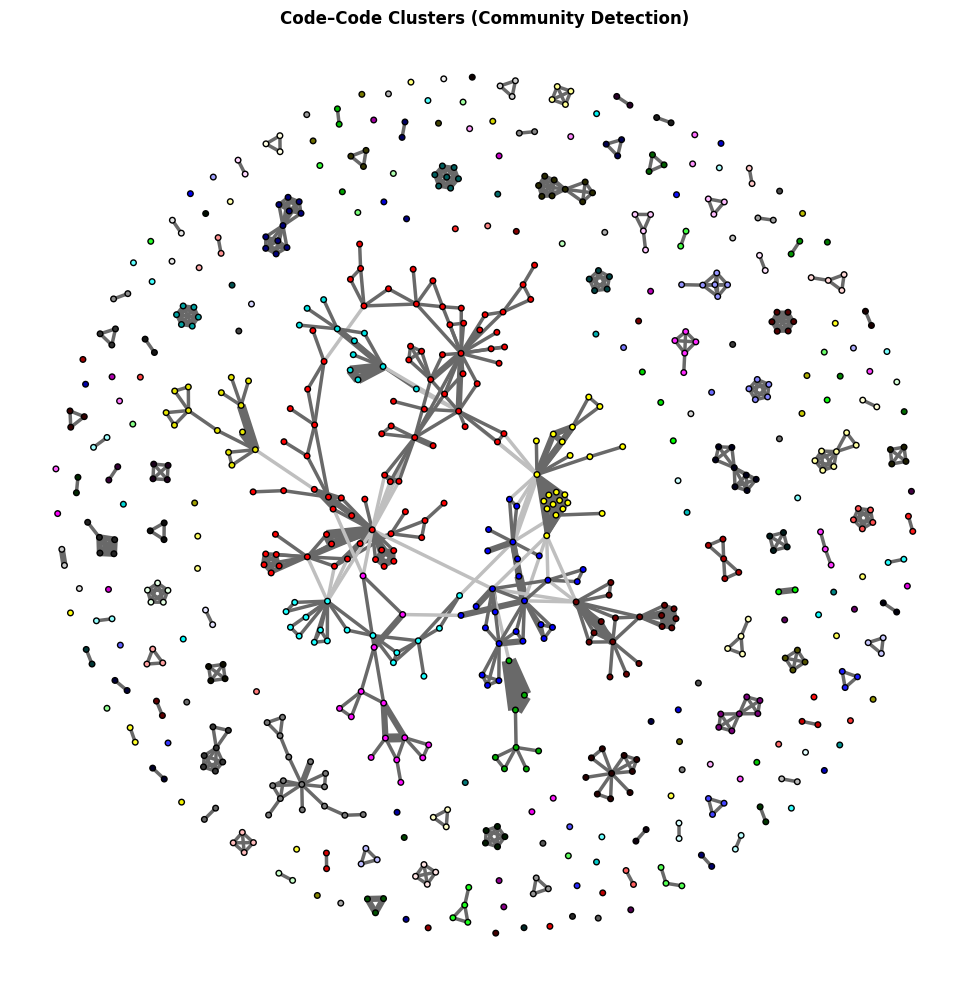

In [196]:
import igraph as ig
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

# 1. FILTER Sentence–Code edges
sentence_nodes = [v.index for v in g.vs if v["type"] == "Sentence"]
code_nodes = [v.index for v in g.vs if v["type"] == "Code"]

# Build bipartite graph edges
bipartite_edges = []
for e in g.es:
    src, tgt = e.source, e.target
    if (src in sentence_nodes and tgt in code_nodes) or (src in code_nodes and tgt in sentence_nodes):
        bipartite_edges.append((src, tgt))

# 2. Project Code–Code network from bipartite edges
# Map: Sentence -> list of Codes
sentence_to_codes = defaultdict(set)

for src, tgt in bipartite_edges:
    if g.vs[src]["type"] == "Sentence":
        sentence = src
        code = tgt
    else:
        sentence = tgt
        code = src
    sentence_to_codes[sentence].add(code)

# Create Code–Code edges (co-occurrence in same sentence)
code_code_edges = defaultdict(int)

for codes in sentence_to_codes.values():
    codes = list(codes)
    for i in range(len(codes)):
        for j in range(i + 1, len(codes)):
            pair = tuple(sorted((codes[i], codes[j])))
            code_code_edges[pair] += 1

# 3. Build the Code–Code network
code_graph = ig.Graph()
code_id_to_idx = {}
for idx in code_nodes:
    v = g.vs[idx]
    new_idx = code_graph.vcount()
    code_graph.add_vertex(name=v["name"], text=v["text"])
    code_id_to_idx[idx] = new_idx

# Add edges
for (i, j), weight in code_code_edges.items():
    code_graph.add_edge(code_id_to_idx[i], code_id_to_idx[j], weight=weight)

# 4. Run community detection
clusters = code_graph.community_multilevel(weights="weight")
membership = clusters.membership

# Assign cluster ID as a new vertex attribute
code_graph.vs["cluster"] = membership

# 5. Plot clusters
layout = code_graph.layout("fr")
fig, ax = plt.subplots(figsize=(12, 10))
ig.plot(
    clusters,
    layout=layout,
    #vertex_label=code_graph.vs["text"],
    vertex_label=None,
    target=ax,
    vertex_size=0.3,
    edge_width=[0.5 + 2 * w for w in code_graph.es["weight"]],
    bbox=(800, 800)
)
plt.title("Code–Code Clusters (Community Detection)", fontweight="bold")
plt.tight_layout()

#plt.savefig(
#    './figures/Code–Code_Community-Detection_(ThirdCC).png', 
#    format='png', 
#    dpi=300,
#    bbox_inches="tight")


plt.show()

# 6. Export sample codes per cluster
cluster_to_codes = defaultdict(list)

for v in code_graph.vs:
    cluster_id = v["cluster"]
    cluster_to_codes[cluster_id].append(v["text"])

# Create DataFrame of samples
cluster_samples = [
    {"Cluster": k, "Sample Codes": ", ".join(v[:5]), "Size": len(v)}  # first 5 codes per cluster
    for k, v in cluster_to_codes.items()
]
df_clusters = pd.DataFrame(cluster_samples)

# Display or export
#import caas_jupyter_tools
#caas_jupyter_tools.display_dataframe_to_user(name="Code Clusters (Top 5 Samples)", dataframe=df_clusters)


In [1125]:
df_clusters.sort_values(by=['Size'], ascending=False).head(5)

Cluster                                       Sample Codes  Size
12       12  prior enabling posterior, data and databases a...    38
3         3  EU innovation measures, EU policy framework, E...    38
5         5  pathway visualization and roadmapping, managem...    35
0         0  business development, dissemination practices,...    28
1         1  research roles and responsibilities, role-base...    26

In [1126]:
top_clusters_ids = df_clusters.sort_values(by=['Size'], ascending=False).head(5).index

### Save the narratives of top-k clusters 

Save the sentences associated to the codes supporting the top-k communities

In [1127]:
# get narratives from the top 5 clusters:

narratives = {}

for i, cl in enumerate(top_clusters_ids):
    
    narratives[i] = []
    tmp = set()
    for code in cluster_to_codes[cl]:
        for s in get_sentences_linked_to_node(g, f'Code:{code}'):
            if s['sentence_id'] not in tmp:
                narratives[i].append(s)
                tmp.add(s['sentence_id'])
    

In [1128]:
import json

for k in narratives.keys():

    with open(f"./report/sentences_in_code-code-communities{k}_all_respondents_ThirdCC.json", "w", encoding="utf-8") as f:
        json.dump(narratives[k], f, indent=2, ensure_ascii=False)

## Create the Code-Theme graph

In [197]:
import igraph as ig
import matplotlib.pyplot as plt

# Get edges between Code and Theme nodes only
edges_to_plot = []
for e in g.es:
    source = g.vs[e.source]
    target = g.vs[e.target]
    types = {source["type"], target["type"]}
    if types == {"Code", "Theme"}:
        edges_to_plot.append(e.index)

# Create a subgraph with only Code–Theme edges and the connected nodes
sub_g = g.subgraph_edges(edges_to_plot, delete_vertices=True)

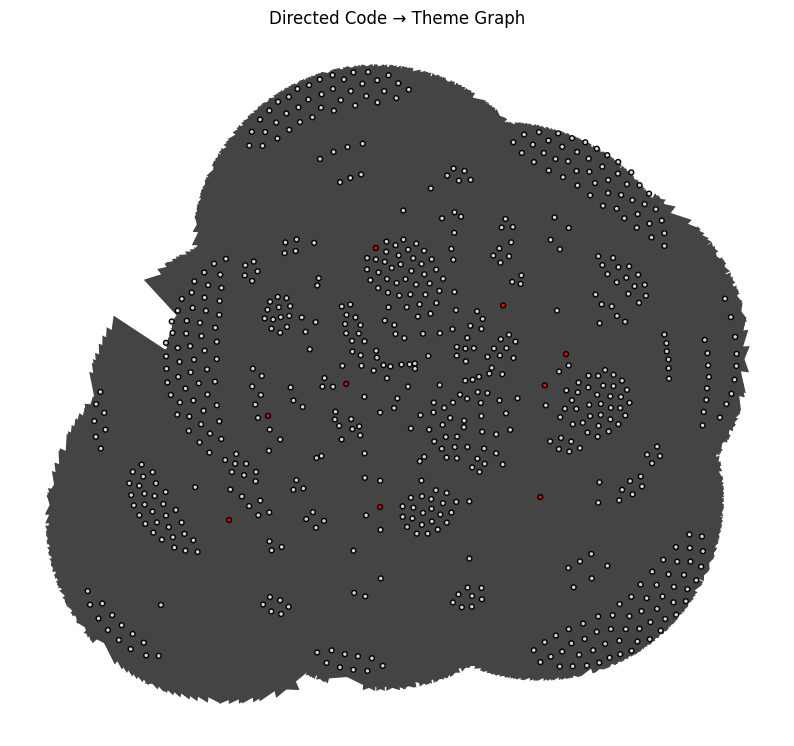

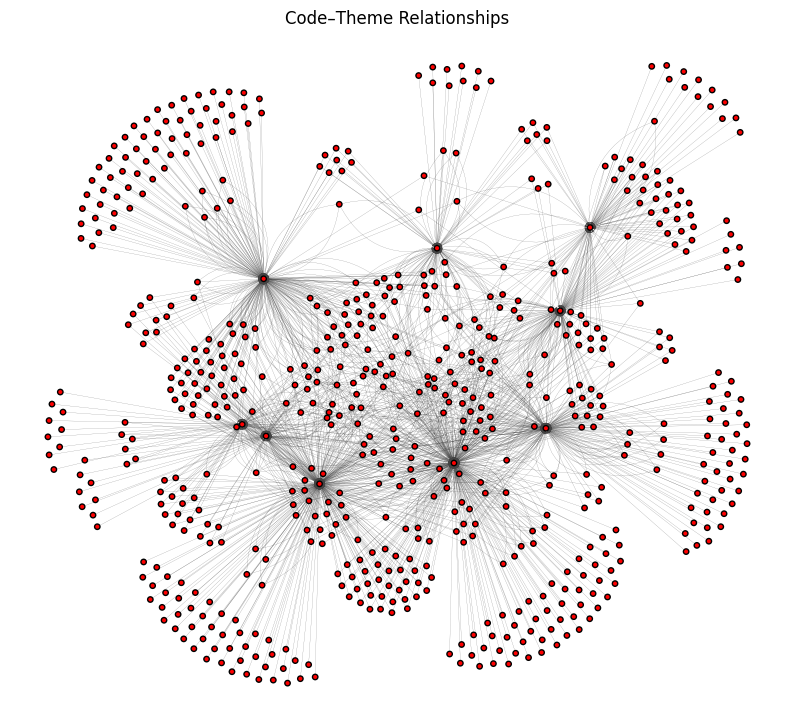

In [534]:
# Plot the subgraph

# Style the nodes and labels
vertex_colors = [
    "red" if v["type"] == "Theme" else "lightgrey"
    for v in sub_g.vs
]

vertex_labels = [
    v["text"] if v["type"] == "Theme" else ""
    for v in sub_g.vs
]



layout = sub_g.layout("fr")
fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(
    sub_g,
    layout=layout,
    target=ax,
    #vertex_label=vertex_labels,
    vertex_label=None, 
    vertex_color=vertex_colors,
    vertex_size=0.2
    ,
    edge_width=.2,
    bbox=(800, 800),
    edge_arrow_size=0.5
)
plt.title("Directed Code → Theme Graph")
plt.show()

layout = sub_g.layout("fr")
fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(
    sub_g,
    layout=layout,
    target=ax,
    #vertex_label=sub_g.vs["text"],
    vertex_label = None,
    vertex_size=0.2,
    edge_width=0.1,
    bbox=(800, 800)
)
plt.title("Code–Theme Relationships")
plt.show()


In [3]:
# Analyse the partitions (here: leiden)

In [207]:
part = detect_communities(sub_g, method="leiden", resolution=1.0)
len(part), part.modularity

(7, 0.46176632360409225)

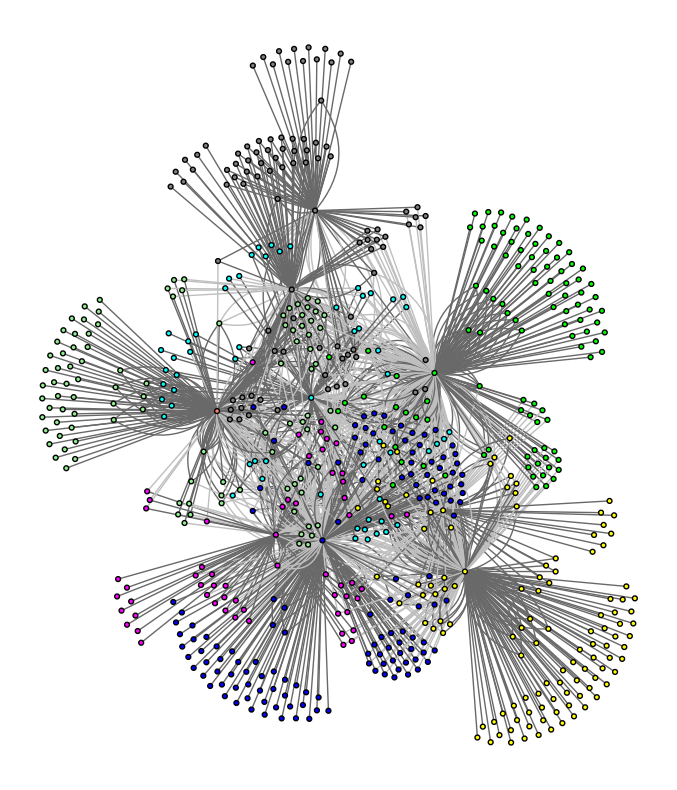

In [209]:
fig, ax = plt.subplots(figsize=(10, 10))

ig.plot(
    part,
    target=ax,
    layout=layout,
    vertex_size=0.2,
    edge_width=1,
    vertex_label=None
)

plt.show()

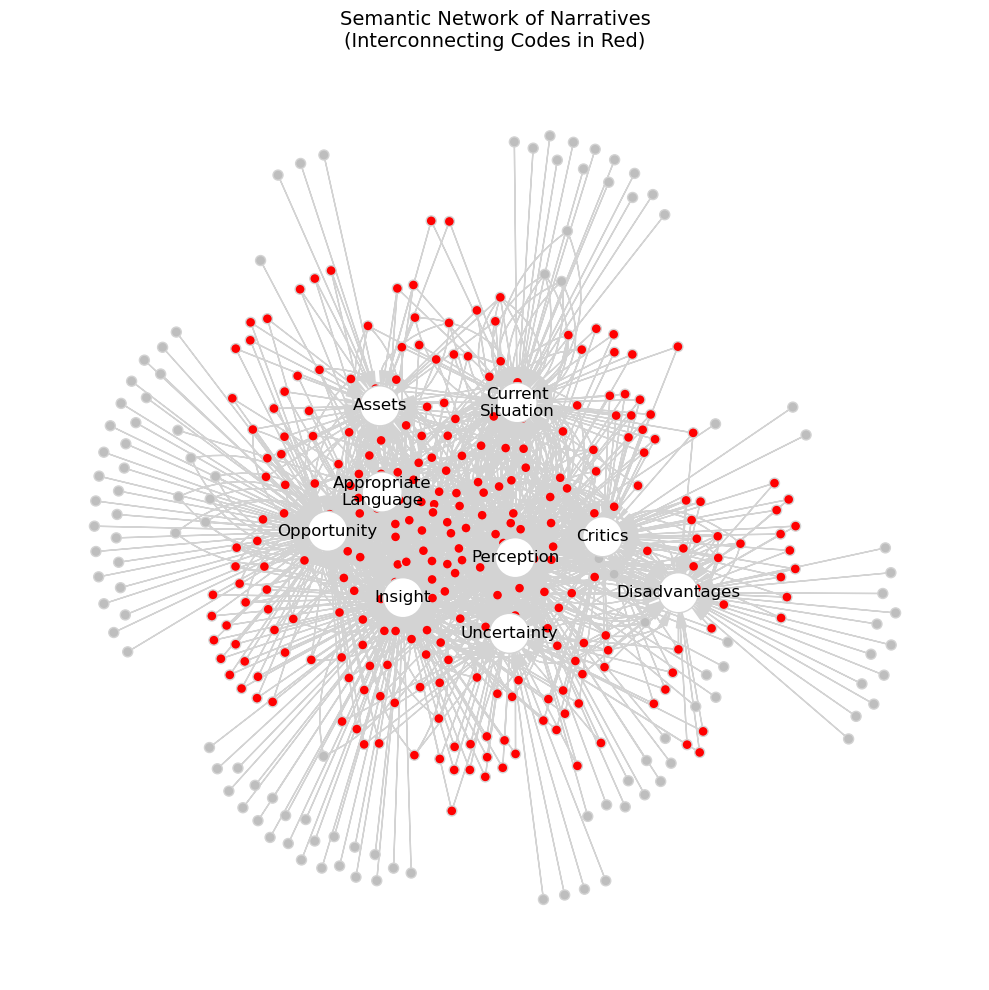

In [1150]:
import igraph as ig
import matplotlib.pyplot as plt

# --- Step 1: Extract directed Code → Theme edges ---
edges_to_plot = []
for e in g.es:
    source = g.vs[e.source]
    target = g.vs[e.target]

    if source["type"] == "Code" and target["type"] == "Theme":
        edges_to_plot.append((e.source, e.target))
    elif source["type"] == "Theme" and target["type"] == "Code":
        # Reverse edge to Code → Theme
        edges_to_plot.append((e.target, e.source))

# --- Step 2: Build subgraph with only Code and Theme nodes used in these edges ---
sub_g = ig.Graph(directed=True)
used_vertex_ids = set(i for edge in edges_to_plot for i in edge)

id_map = {}
for old_id in sorted(used_vertex_ids):
    v = g.vs[old_id]
    new_id = sub_g.vcount()
    sub_g.add_vertex(
        name=v["name"],
        text=v["text"] if "text" in v.attributes() else v["name"],
        type=v["type"]
    )
    id_map[old_id] = new_id

# Add edges (Code → Theme)
for source, target in edges_to_plot:
    sub_g.add_edge(id_map[source], id_map[target])

# --- Step 3: Detect interconnecting Codes (linked to 2+ Themes) ---
interconnecting_code_ids = set()

for v in sub_g.vs:
    if v["type"] != "Code":
        continue
        
    # Get targets of outgoing edges
    theme_targets = set(
        tgt for tgt in sub_g.neighbors(v.index, mode="out")
        if sub_g.vs[tgt]["type"] == "Theme"
    )
    if len(theme_targets) >= 2:
        interconnecting_code_ids.add(v.index)

# --- Step 4: Styling ---
vertex_colors = []
vertex_labels = []
vertex_label_dist = []
vertex_sizes = []

for v in sub_g.vs:
    if v["type"] == "Theme":
        vertex_colors.append("white")
        vertex_labels.append(v["text"].replace(' ','\n').title())
        vertex_label_dist.append(0)
        vertex_sizes.append(40)
    elif v.index in interconnecting_code_ids:
        vertex_colors.append("red")  # Highlight interconnecting Code
        vertex_labels.append("")
        vertex_label_dist.append(10)
        vertex_sizes.append(10)
    else:
        vertex_colors.append("grey")
        vertex_labels.append("")
        vertex_label_dist.append(0)
        vertex_sizes.append(10)

#vertex_sizes = [10] * sub_g.vcount()
edge_colors = ["lightgrey"] * sub_g.ecount()

# --- Step 5: Plot (no arrowheads in matplotlib mode) ---
layout = sub_g.layout("fr")
fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(
    sub_g,
    layout=layout,
    target=ax,
    vertex_label=vertex_labels,
    vertex_color=vertex_colors,
    vertex_label_dist = vertex_label_dist,
    vertex_size=vertex_sizes,
    vertex_frame_color='lightgrey',
    edge_arrow_width = 4,
    edge_color=edge_colors,
    edge_width=1.0,
    bbox=(800, 800),
    margin=40
)

plt.title("Semantic Network of Narratives\n(Interconnecting Codes in Red)", fontsize=14)
plt.tight_layout()

plt.savefig(
    './figures/Semantic_Network_Narratives_(ThirdCC).png', 
    format='png', 
    dpi=300,
    bbox_inches="tight")

plt.show()


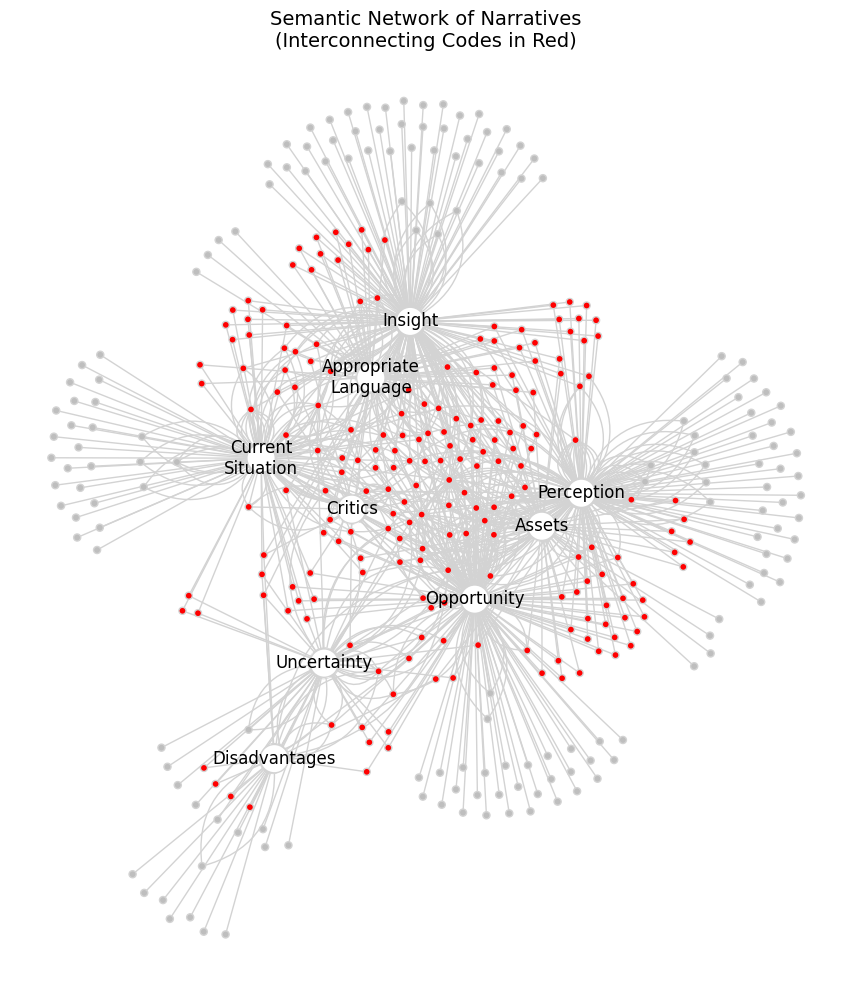

In [609]:
import igraph as ig
import matplotlib.pyplot as plt

# --- Step 1: Extract directed Code → Theme edges ---
edges_to_plot = []
for e in g.es:
    source = g.vs[e.source]
    target = g.vs[e.target]

    if source["type"] == "Code" and target["type"] == "Theme":
        edges_to_plot.append((e.source, e.target))
    elif source["type"] == "Theme" and target["type"] == "Code":
        # Reverse edge to Code → Theme
        edges_to_plot.append((e.target, e.source))

# --- Step 2: Build subgraph with only Code and Theme nodes used in these edges ---
sub_g = ig.Graph(directed=True)
used_vertex_ids = set(i for edge in edges_to_plot for i in edge)

id_map = {}
for old_id in sorted(used_vertex_ids):
    v = g.vs[old_id]
    new_id = sub_g.vcount()
    sub_g.add_vertex(
        name=v["name"],
        text=v["text"] if "text" in v.attributes() else v["name"],
        type=v["type"]
    )
    id_map[old_id] = new_id

# Add edges (Code → Theme)
for source, target in edges_to_plot:
    sub_g.add_edge(id_map[source], id_map[target])

# --- Step 3: Detect interconnecting Codes (linked to 2+ Themes) ---
interconnecting_code_ids = set()

for v in sub_g.vs:
    if v["type"] != "Code":
        continue
        
    # Get targets of outgoing edges
    theme_targets = set(
        tgt for tgt in sub_g.neighbors(v.index, mode="out")
        if sub_g.vs[tgt]["type"] == "Theme"
    )
    if len(theme_targets) >= 2:
        interconnecting_code_ids.add(v.index)

# --- Step 4: Styling ---
vertex_colors = []
vertex_labels = []
vertex_label_dist = []
vertex_sizes = []

for v in sub_g.vs:
    if v["type"] == "Theme":
        vertex_colors.append("white")
        vertex_labels.append(v["text"].replace(' ','\n').title())
        vertex_label_dist.append(0)
        vertex_sizes.append(.8)
    elif v.index in interconnecting_code_ids:
        vertex_colors.append("red")  # Highlight interconnecting Code
        vertex_labels.append("")
        vertex_label_dist.append(10)
        vertex_sizes.append(.20)
    else:
        vertex_colors.append("grey")
        vertex_labels.append("")
        vertex_label_dist.append(0)
        vertex_sizes.append(.20)

#vertex_sizes = [10] * sub_g.vcount()
edge_colors = ["lightgrey"] * sub_g.ecount()

# --- Step 5: Plot (no arrowheads in matplotlib mode) ---
layout = sub_g.layout("fr")
fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(
    sub_g,
    layout=layout,
    target=ax,
    vertex_label=vertex_labels,
    vertex_color=vertex_colors,
    vertex_label_dist = vertex_label_dist,
    vertex_size=vertex_sizes,
    vertex_frame_color='lightgrey',
    edge_arrow_width = 4,
    edge_color=edge_colors,
    edge_width=1.0,
    bbox=(800, 800),
    margin=40
)

plt.title("Semantic Network of Narratives\n(Interconnecting Codes in Red)", fontsize=14)
plt.tight_layout()

plt.savefig(
    './figures/Semantic_Network_Narratives_(FirstCC)_ecq_first4.png', #_ICQ  = included closed quetions, _EXQ = excluded closed questions
    format='png', 
    dpi=300,
    bbox_inches="tight")

plt.show()


In [1135]:
from collections import Counter
print(Counter(sub_g.vs["type"]))

Counter({'Code': 387, 'Theme': 9})


In [674]:
g.vs[2]

igraph.Vertex(<igraph.Graph object at 0x153f43950>, 2, {'node_id': 'R0:6', 'text': 'We will analyze insights from a first screening of stakeholders and will discuss with them our findings on the [date], to check if priorities are aligned.', 'type': 'Sentence', 'name': 'R0:6', 'color': 'skyblue', 'label': 'We will analyze insights from a first screening of stakeholders and will discuss with them our findings on the [date], to check if priorities are aligned.'})

In [676]:
set(sub_g.vs["type"])

{'Code', 'Theme'}

In [677]:
[v.index for v in sub_g.vs if "type" not in v.attributes() or not v["type"]]

[]

In [ ]:
clusters = sub_g.community_multilevel()


In [681]:
clusters = part

In [683]:
palette = ig.drawing.colors.ClusterColoringPalette(len(clusters))

In [684]:
from scipy.spatial import ConvexHull
import numpy as np

for cluster_id in range(len(clusters)):
    cluster_vertices = clusters[cluster_id]
    coords = np.array([layout[v] for v in cluster_vertices])

    if len(coords) >= 3:
        hull = ConvexHull(coords)
        polygon = coords[hull.vertices]
        ax.fill(*zip(*polygon), alpha=0.1, color=palette[cluster_id])

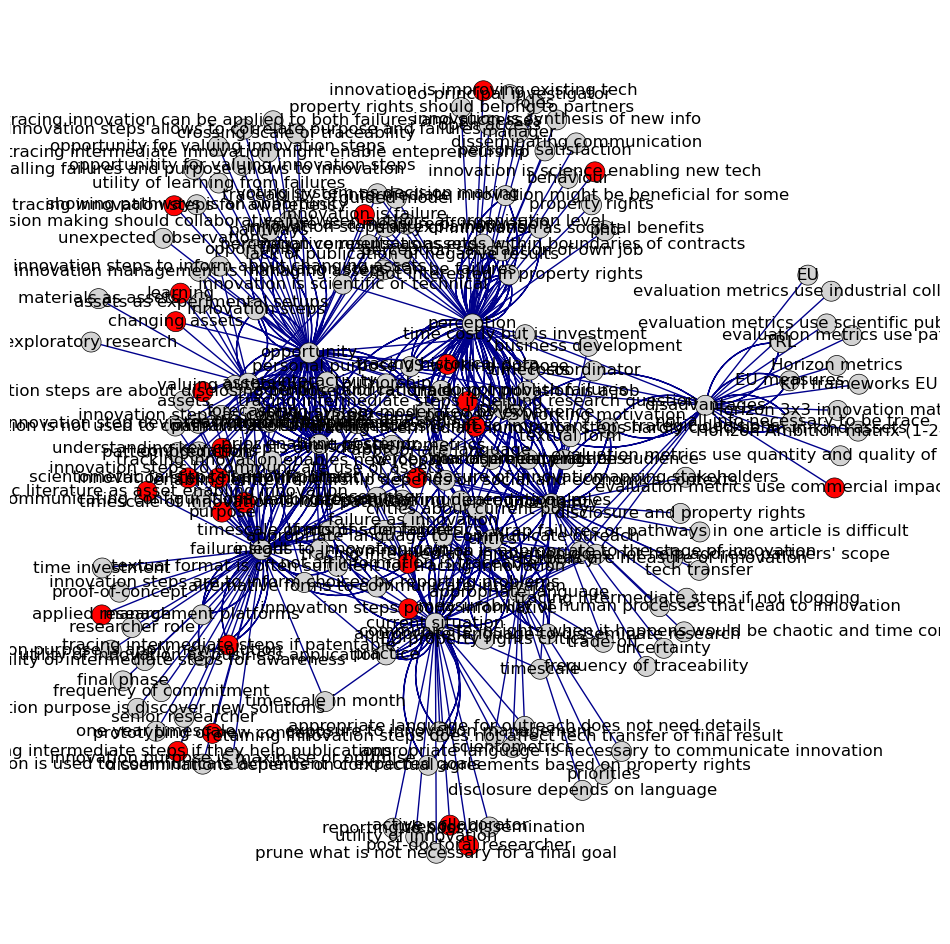

In [687]:
fig, ax = plt.subplots(figsize=(12, 12))
ig.plot(
    sub_g,
    layout=layout,
    target=ax,
    vertex_color=colors,
    vertex_label=[v["text"] if v["type"] == "Theme" else "" for v in sub_g.vs],
    vertex_size=20,
    edge_width=1,
    edge_arrow_size=0.4,
    edge_color="darkblue",
    vertex_frame_width=0.5
)

In [ ]:
import matplotlib.pyplot as plt
import igraph as ig
import numpy as np
from scipy.spatial import ConvexHull


# Compute layout and community
layout = sub_g.layout("fr")
clusters = sub_g.community_multilevel()

# Color nodes by cluster
palette = ig.drawing.colors.ClusterColoringPalette(len(clusters))
colors = [palette[clusters.membership[v.index]] for v in sub_g.vs]

# Prepare plot
fig, ax = plt.subplots(figsize=(10, 10))

# Draw graph
ig.plot(
    sub_g,
    layout=layout,
    target=ax,
    vertex_color=colors,
    #vertex_label=[v["text"] if v["type"] == "Theme" else "" for v in sub_g.vs],
    vertex_label = None,
    vertex_size=20,
    edge_width=1,
    edge_arrow_size=0.4,
    edge_color="lightgrey",
    vertex_frame_width=0.5,
    bbox=(800, 800)
)

# Draw convex hulls around clusters
for cluster_id, cluster in enumerate(clusters):
    coords = np.array([layout[v] for v in cluster])
    if len(coords) >= 3:
        try:
            hull = ConvexHull(coords)
            polygon = coords[hull.vertices]
            ax.fill(*zip(*polygon), alpha=0.2, color=palette[cluster_id])
        except:
            pass  # skip degenerate hulls

plt.title("Community Visualization with Convex Hulls")
plt.axis("off")
plt.show()


## Query the Themes

Analyse intersection, union or differerences of codes associated to a theme.

In [1137]:
def query_theme_codes(g, theme_a, theme_b=None, operation="intersection"):
    """
    Query the set of Codes connected to one or two Themes in graph `g`.

    Parameters:
    - g: igraph.Graph object
    - theme_a: name of the first Theme node (str)
    - theme_b: name of the second Theme node (str), optional
    - operation: 'intersection', 'union', or 'difference'

    Returns:
    - Set of Code node names (or a list, if preferred)
    """
    def get_codes(theme_name):
        # Get theme vertex
        theme_v = g.vs.find(name= 'Theme:'+theme_name)
        # Get incoming edges to this theme from Codes
        code_neighbors = g.neighbors(theme_v, mode="in")
        # Filter those neighbors that are Codes
        return set(
            g.vs[v]["name"] for v in code_neighbors if g.vs[v]["type"] == "Code"
        )
    
    codes_a = get_codes(theme_a)

    if not theme_b:
        return codes_a
    
    codes_b = get_codes(theme_b)

    if operation == "intersection":
        return codes_a & codes_b
    elif operation == "union":
        return codes_a | codes_b
    elif operation == "difference":
        return codes_a - codes_b
    else:
        raise ValueError("operation must be one of: 'intersection', 'union', 'difference'")


In [1138]:
query_theme_codes(sub_g, 'opportunity', 'insight', 'intersection')

{'Code:IP governance and disclosure',
 'Code:ML-based forecasting',
 'Code:accountability',
 'Code:appropriate language',
 'Code:asset-related communication',
 'Code:assets as innovation components',
 'Code:authorship and rewards',
 'Code:communication as transparency reporting',
 'Code:communication of configurations leading to results',
 'Code:communication practices',
 'Code:conditional tracing criteria',
 'Code:configurations leading to outcomes',
 'Code:coordination practices',
 'Code:cross-disciplinary mapping and connectivity',
 'Code:data formats for describing steps',
 'Code:deviation and pivot points',
 'Code:disclosure of purpose and rationale',
 'Code:dissemination framed as marketing',
 'Code:dissemination practices',
 'Code:enabling research bifurcation',
 'Code:failure timescale and learning cycles',
 'Code:failures and negative results',
 'Code:forecasting and predictive modeling',
 'Code:high-level updates practices',
 'Code:ideas as innovation indicator',
 'Code:impor

In [1140]:
query_theme_codes(sub_g, 'perception', 'critics', 'intersection')

{'Code:EU context',
 'Code:IP governance and disclosure',
 'Code:IP risk management',
 'Code:accountability',
 'Code:appropriate language',
 'Code:audience-dependent disclosure',
 'Code:authorship and rewards',
 'Code:communication timing and frequency',
 'Code:competitive disadvantage risk',
 'Code:conditional idea disclosure',
 'Code:criticism of current project',
 'Code:criticism of current tools',
 'Code:criticism of data mining',
 'Code:criticism of datafication policies',
 'Code:criticism of innovation management',
 'Code:criticism of internal project management',
 'Code:criticism of outreach choices',
 'Code:criticism of policy',
 'Code:criticism of property rights',
 'Code:criticism of voting systems',
 'Code:distrust in activity tracking and inference',
 'Code:distrust in datification policies',
 'Code:experience-moderated voting',
 'Code:frustration with non-democratic governance',
 'Code:innovation management skepticism',
 'Code:innovation management tools and platforms',
 '

In [ ]:
# Codes linked to both Themes
query_theme_codes(g, "opportunity", "insight", operation="intersection")

# Codes in Uncertainty OR Disadvantages
query_theme_codes(g, "Uncertainty", "Disadvantages", operation="union")

# Codes in Opportunity but not in Insight
#query_theme_codes(g, "Opportunity", "Insight", operation="difference")

In [29]:
from collections import Counter

def query_theme_codes(g, theme_a, theme_b=None, operation="intersection", return_counts=True):
    """
    Query the set of Codes connected to one or two Themes in graph `g`.

    Parameters:
    - g: igraph.Graph object
    - theme_a: name of the first Theme node (str)
    - theme_b: name of the second Theme node (str), optional
    - operation: 'intersection', 'union', or 'difference'
    - return_counts: if True, return list of (code_name, count), sorted by count

    Returns:
    - List of (code_name, count) tuples if return_counts is True
    - Otherwise, set of Code node names
    """
    def get_codes(theme_name):
        theme_v = g.vs.find(name='Theme:' + theme_name)
        code_neighbors = g.neighbors(theme_v, mode="in")
        return [g.vs[v]["name"] for v in code_neighbors if g.vs[v]["type"] == "Code"]

    codes_a = get_codes(theme_a)

    if not theme_b:
        result = codes_a
    else:
        codes_b = get_codes(theme_b)

        if operation == "intersection":
            result = list(set(codes_a) & set(codes_b))
        elif operation == "union":
            result = codes_a + codes_b  # we'll count duplicates later
        elif operation == "difference":
            result = list(set(codes_a) - set(codes_b))
        else:
            raise ValueError("operation must be one of: 'intersection', 'union', 'difference'")

    if return_counts:
        return Counter(result).most_common()
    else:
        return set(result)


In [30]:
# Codes linked to both Themes
query_theme_codes(g, "opportunity", "insight", operation="intersection")


[('Code:dissemination', 1),
 ('Code:pattern prediction', 1),
 ('Code:innovation steps are about disclosing purpose and rationale', 1),
 ('Code:dissemination innovation is marketing', 1),
 ('Code:scientometric fails to tell prior failures', 1),
 ('Code:valuing authorship', 1),
 ('Code:vertical axes leading to unexpected event', 1),
 ('Code:high level updates', 1),
 ('Code:prototypes are measure of innovation', 1),
 ('Code:decision making depending on roles', 1),
 ('Code:pathways from connectivities', 1),
 ('Code:tracing innovation steps to understand patterns of processes leading to new innovations',
  1),
 ('Code:communication', 1),
 ('Code:utility of learning from failures', 1),
 ('Code:innovation steps VS innovation milestones', 1),
 ('Code:third party communication', 1),
 ('Code:research goals', 1),
 ('Code:assets', 1),
 ('Code:innovation steps as explainations', 1),
 ('Code:innovation steps to communicate use of assets', 1),
 ('Code:negative results are not failures', 1),
 ('Code:i

In [31]:
from collections import defaultdict

def query_theme_codes(g, theme_a, theme_b=None, operation="intersection", return_counts=True):
    """
    Query the set of Codes connected to one or two Themes in graph `g`.

    Parameters:
    - g: igraph.Graph object
    - theme_a: name of the first Theme node (str)
    - theme_b: name of the second Theme node (str), optional
    - operation: 'intersection', 'union', or 'difference'
    - return_counts: if True, return list of (code_name, count_of_themes_it_links_to)

    Returns:
    - List of (code_name, count), or set of code names
    """
    def get_theme_vertex(theme_name):
        return g.vs.find(name="Theme:" + theme_name)

    def get_codes_for_theme(theme_vertex):
        code_neighbors = g.neighbors(theme_vertex, mode="in")
        return {
            g.vs[v]["name"]: g.vs[v]
            for v in code_neighbors
            if g.vs[v]["type"] == "Code"
        }

    theme_vs = [get_theme_vertex(theme_a)]
    if theme_b:
        theme_vs.append(get_theme_vertex(theme_b))

    code_theme_count = defaultdict(int)

    for theme_v in theme_vs:
        for code_name in get_codes_for_theme(theme_v):
            code_theme_count[code_name] += 1

    # Apply operation
    if operation == "intersection":
        result = {k: v for k, v in code_theme_count.items() if v == len(theme_vs)}
    elif operation == "union":
        result = code_theme_count
    elif operation == "difference" and theme_b:
        result = {k: v for k, v in code_theme_count.items() if v == 1 and k in get_codes_for_theme(theme_vs[0])}
    else:
        result = get_codes_for_theme(theme_vs[0])

    if return_counts:
        return sorted(result.items(), key=lambda x: x[1], reverse=True)
    else:
        return set(result.keys())


In [727]:
query_theme_codes(g, "opportunity", "insight", operation="difference")

[('Code:innovation management is managing assets', 1),
 ('Code:appropriate language', 1),
 ('Code:timecosts', 1),
 ('Code:decision making should collaborative between authors at organisation level',
  1),
 ('Code:available resources as assets', 1),
 ('Code:innovation is failure', 1),
 ('Code:innovation steps can be failures', 1),
 ('Code:failure as a measure of innovation', 1),
 ('Code:lack of publication of negative results', 1),
 ('Code:negative results as assets', 1),
 ('Code:unexpected observations', 1),
 ('Code:scientific publications do not publish failures', 1),
 ('Code:tracking innovation is a job', 1),
 ('Code:tracing innovation can be applied to both failures and successes', 1),
 ('Code:utility of learning from failures', 1),
 ('Code:innovation steps allows to correlate purpose and failures', 1),
 ('Code:recalling failures and purpose allows to innovation', 1),
 ('Code:limits of scientometrics', 1),
 ('Code:opportunitity for valuing innovation steps', 1),
 ('Code:opportunity 

## Inspecting the Information Coverage of the Themes (Saturation)

In [4]:
# Convert Codes list into sets, to then count codes per themes and prepare the df

In [904]:
df_merged['Codes'] = df_merged['ThirdCC'].str.split(',')
df_merged['Codes'] = df_merged['ThirdCC'].apply(lambda x : {c.strip() for c in x})
df_merged['Codes'] = df_merged['ThirdCC'].apply(set)

df_merged['Themes'] = df_merged['Themes'].str.split(',')
df_merged['Themes'] = df_merged['Themes'].apply(lambda x : {c.strip() for c in x})
df_merged['Themes'] = df_merged['Themes'].apply(set)

In [905]:
df_merged['Themes'] = df_merged['Themes'].str.split(',')
df_merged['Themes'] = df_merged['Themes'].apply(lambda x : {c.strip() for c in x})
df_merged['Themes'] = df_merged['Themes'].apply(set)

In [906]:
df_merged.head()

ID QID QID_                                           Sentence  \
0  R0:3           Respondent: I am manager and responsible for d...   
1  R0:5           Respondent: In this specific project we starte...   
2  R0:6           We will analyze insights from a first screenin...   
3  R0:7           This is a project very much focused on researc...   
4  R0:9           So dissemination is a type of marketing, we ca...   

                                               Codes  \
0  {business development, disseminating communica...   
1  {business development, mapping stakeholders, t...   
2                                       {priorities}   
3                      {EU measures, EU policy, TRL}   
4                       {dissemination as marketing}   

                         Themes  
0                  {perception}  
1           {current situation}  
2           {current situation}  
3  {insight, current situation}  
4                     {insight}

In [148]:
df_exploded = df_merged.explode('Themes')

In [149]:
codes_by_theme = (
    df_exploded
        .groupby('Themes')['Codes']
        .apply(lambda x: set().union(*x))
)

In [152]:
codes_by_theme.index.tolist()
codes_by_theme.pop('')

{'brevity preference',
 'credibility',
 'data-visualisation tools are very important to strategise roadmap (5/5)',
 'delegation of commercialization',
 'innovation lastly aims to accelarate business',
 'interface design guidelines',
 'knowledge exchange',
 'market awareness (not market driven)',
 'outreach',
 'public engagement',
 'rejection of researcher-as-businessman',
 'science visibility',
 'science vs market logic',
 'scientific contribution)',
 'stem inspiration)',
 'synergy identification',
 'technology transfer as mediator',
 'traceability of innovation should be open to everybody (c)',
 'tracing innovation advantages (generic audiences: public trust',
 'tracing innovation advantages (third party sci tech audiences: collaboration',
 "tracing intermediate innovation does not help address partners' scope",
 'tracing intermediate steps if patentable'}

In [151]:
codes_by_theme

Themes
                        {public engagement, science visibility, data-v...
appropriate language    {, describing innovation steps with minutiae i...
assets                  {describing innovation steps with minutiae is ...
critics                 {property rights critics, , management focus o...
current situation       {, co-principal investigator, perception of pr...
disadvantages           {, disadvantages of traceability open to all p...
insight                 {property rights critics, , scientific outputs...
opportunity             {course correction, communicating and engaging...
perception              {, legal and IP support are also in-kind resou...
uncertainty             {, timecosts, disadvantages of traceability op...
Name: Codes, dtype: object

In [914]:
codes_by_theme.apply(lambda x : len(x)).tolist()

[70, 74, 116, 141, 86, 241, 203, 255, 73]

In [918]:
df_exploded

ID QID  QID_                                           Sentence  \
0      R0:3            Respondent: I am manager and responsible for d...   
1      R0:5            Respondent: In this specific project we starte...   
2      R0:6            We will analyze insights from a first screenin...   
3      R0:7            This is a project very much focused on researc...   
3      R0:7            This is a project very much focused on researc...   
..      ...  ..   ...                                                ...   
575  R9:162      Q:33  Information processing using biological materi...   
575  R9:162      Q:33  Information processing using biological materi...   
576  R9:165      Q:34  Pros include traceability, ethical responsibil...   
577  R9:166      Q:34  The cons are that by exposing every step, we a...   
578  R9:168      Q:35  By documenting all steps, we can trace the evo...   

                                                 Codes             Themes  
0    {business development, disseminating communica...         perception  
1    {business development, mapping stakeholders, t...  current situation  
2                                         {priorities}  current situation  
3                        {EU measures, EU policy, TRL}            insight  
3                        {EU measures, EU policy, TRL}  current situation  
..                                                 ...                ...  
575  {adequate communication to engage public, diss...        opportunity  
575  {adequate communication to engage public, diss...         perception  
576  {tracing innovation steps aids ethical respons...        opportunity  
577  {psychological anxiety, tracing innovation exp...      disadvantages  
578  {showing pathways can aid to correct research ...        opportunity  

[842 rows x 6 columns]

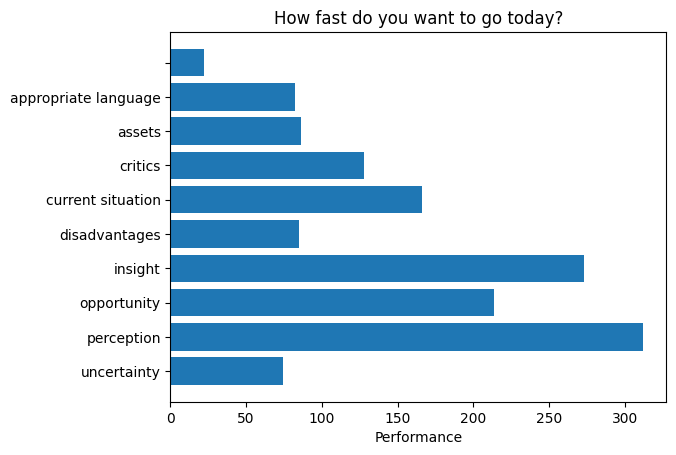

In [150]:
fig, ax = plt.subplots()

# Example data
themes = codes_by_theme.index.tolist()
y_pos = np.arange(len(themes))
values = codes_by_theme.apply(lambda x : len(x)).tolist()

ax.barh(y_pos, values, align='center')
ax.set_yticks(y_pos, labels=themes)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('Counts of codes by Themes')

plt.show()


In [890]:
# test
set.intersection(
    #codes_by_theme['uncertainty'],
    codes_by_theme['perception'],
    codes_by_theme['critics']
)

{'Voting on innovation steps encourages engagement but risks early disclosure.'}

In [916]:
import itertools

theme_code_sets = codes_by_theme.tolist()
n = len(theme_code_sets)

unalike = 0
total = 0

for a, b in itertools.permutations(theme_code_sets, 2):
    total += 1
    if a != b:
        unalike += 1

U = unalike / total
U


1.0

### Uncertainty

In [1166]:
headers = ['Themes', 'FirstCC','SecondCC', 'ThirdCC']

In [1198]:
df_uncertainty = df_merged[headers].explode('Themes').explode('FirstCC').explode('SecondCC').explode('ThirdCC')

In [1181]:
# uncertainty for themes: diversity of themes (probability that two randomly selected instances of theme assignments will be in different categories)
1 - df_uncertainty['Themes'].value_counts(normalize=True).apply(lambda x : x**2 ).sum()

0.8767233432299808

In [1182]:
# uncertainty for codes: diversity of codes (probability that two randomly selected instances of code assignments will be in different categories)
1 - df_uncertainty['FirstCC'].value_counts(normalize=True).apply(lambda x : x**2 ).sum()

0.9961800784675786

In [1183]:
# uncertainty for codes: diversity of codes (probability that two randomly selected instances of code assignments will be in different categories)
1 - df_uncertainty['SecondCC'].value_counts(normalize=True).apply(lambda x : x**2 ).sum()

0.9959383213355227

In [1184]:
# uncertainty for codes: diversity of codes (probability that two randomly selected instances of code assignments will be in different categories)
1 - df_uncertainty['ThirdCC'].value_counts(normalize=True).apply(lambda x : x**2 ).sum()

0.9931309788009679

In [1188]:
df_uncertainty = df_merged[['Themes','FirstCC']].explode('Themes').explode('FirstCC')

In [1189]:
1 - df_uncertainty['Themes'].value_counts(normalize=True).apply(lambda x : x**2 ).sum()

0.8612170442211408

In [1190]:
df_uncertainty = df_merged[['Themes','ThirdCC']].explode('Themes').explode('ThirdCC')

In [1191]:
1 - df_uncertainty['Themes'].value_counts(normalize=True).apply(lambda x : x**2 ).sum()

0.8613115378753239

In [1192]:
df_uncertainty = df_merged[['Themes']].explode('Themes')

In [1193]:
1 - df_uncertainty['Themes'].value_counts(normalize=True).apply(lambda x : x**2 ).sum()

0.8516821728606812

In [1194]:
df_merged

ID QID  QID_                                           Sentence  \
0      R0:3            Respondent: I am manager and responsible for d...   
1      R0:5            Respondent: In this specific project we starte...   
2      R0:6            We will analyze insights from a first screenin...   
3      R0:7            This is a project very much focused on researc...   
4      R0:9            So dissemination is a type of marketing, we ca...   
..      ...  ..   ...                                                ...   
574  R9:160      Q:32  Exciting ones. If it is too small the general ...   
575  R9:162      Q:33  Information processing using biological materi...   
576  R9:165      Q:34  Pros include traceability, ethical responsibil...   
577  R9:166      Q:34  The cons are that by exposing every step, we a...   
578  R9:168      Q:35  By documenting all steps, we can trace the evo...   

                                                 Codes  \
0    {business development, disseminating communica...   
1    {business development, mapping stakeholders, t...   
2                                         {priorities}   
3                        {EU measures, EU policy, TRL}   
4                         {dissemination as marketing}   
..                                                 ...   
574  {disclosure depends on audience, communication...   
575  {adequate communication to engage public, diss...   
576  {tracing innovation steps aids ethical respons...   
577  {psychological anxiety, tracing innovation exp...   
578  {showing pathways can aid to correct research ...   

                           Themes  \
0                    {perception}   
1             {current situation}   
2             {current situation}   
3    {insight, current situation}   
4                       {insight}   
..                            ...   
574        {appropriate language}   
575     {opportunity, perception}   
576                 {opportunity}   
577               {disadvantages}   
578                 {opportunity}   

                                               FirstCC  \
0    {business development, disseminating communica...   
1    {business development, mapping stakeholders, t...   
2                                         {priorities}   
3                        {EU measures, EU policy, TRL}   
4                         {dissemination as marketing}   
..                                                 ...   
574  {disclosure depends on audience, communication...   
575  {adequate communication to engage public, diss...   
576  {tracing innovation steps aids ethical respons...   
577  {psychological anxiety, tracing innovation exp...   
578  {showing pathways can aid to correct research ...   

                                              SecondCC  \
0    {business development, dissemination practices...   
1    {business development, mapping stakeholders, t...   
2                                         {priorities}   
3    {EU innovation measures, technology readiness ...   
4                         {dissemination as marketing}   
..                                                 ...   
574  {audience-dependent disclosure, selective disc...   
575  {adequate communication for public engagement,...   
576  {open access practice, personal satisfaction, ...   
577  {psychological anxiety, full exposure risk, co...   
578  {pathway visualization reveals patterns, real-...   

                                               ThirdCC  
0    {business development, dissemination practices...  
1    {business development, tech transfer and marke...  
2                                         {priorities}  
3    {EU innovation measures, EU policy framework, ...  
4                  {dissemination framed as marketing}  
..                                                 ...  
574  {outreach and public engagement communication,...  
575  {dissemination framed as marketing, public eng...  
576  {psychological outcomes, open access pract

### Internal Gini index mutability

In [1281]:
headers = ['Themes', 'ThirdCC']
df_uncertainty = df_merged[headers].explode('Themes').explode('ThirdCC')

In [1282]:
def calculate_gini_internal(group_of_codes):
    # Calcola le proporzioni (p_i) di ciascun codice all'interno del gruppo
    proportions = group_of_codes.value_counts(normalize=True)
    # Calcola la somma dei quadrati delle proporzioni (sum p_i^2)
    sum_of_squares = (proportions ** 2).sum()
    # Gini = 1 - (sum p_i^2)
    gini_index = 1 - sum_of_squares
    return gini_index

# Applica la funzione raggruppando per tema
gini_per_theme = df_uncertainty.groupby('Themes')['ThirdCC'].apply(calculate_gini_internal)

print(gini_per_theme)

Themes
                        0.944444
appropriate language    0.958097
assets                  0.974480
critics                 0.979753
current situation       0.984350
disadvantages           0.980579
insight                 0.991175
opportunity             0.988235
perception              0.988003
uncertainty             0.973280
Name: ThirdCC, dtype: float64


In [1283]:
g = df_uncertainty.groupby('Themes')['ThirdCC']



In [1284]:
1- g.groups['assets'].value_counts(normalize=True).apply(lambda x : x**2).sum()

0.9650283553875236

In [1285]:
for k in g.groups.keys():
    print(k, 1- g.groups[k].value_counts(normalize=True).apply(lambda x : x**2).sum() )

 0.8209876543209876
appropriate language 0.9721048182586645
assets 0.9650283553875236
critics 0.9755829903978052
current situation 0.9877
disadvantages 0.9668384198705245
insight 0.9918457287949799
opportunity 0.9896501345636294
perception 0.993231912350255
uncertainty 0.9761630142252979


In [1279]:
set(df_uncertainty[df_uncertainty['Themes'] == 'perception']['FirstCC'].values);

In [1280]:
for k in g.groups.keys():
    print(k, len(set(g.groups[k].values)))

 8
appropriate language 50
assets 37
critics 51
current situation 108
disadvantages 40
insight 162
opportunity 135
perception 194
uncertainty 57


### Mutual information

In [1287]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

# Note: 'Themes' column must be a list of lists..
mlb = MultiLabelBinarizer()
df_themes_inc = pd.DataFrame(mlb.fit_transform(df_merged['Themes']), columns=mlb.classes_, index=df_merged.index)


In [1288]:
df_themes_inc

appropriate language  assets  critics  current situation  \
0    0                     0       0        0                  0   
1    0                     0       0        0                  1   
2    0                     0       0        0                  1   
3    0                     0       0        0                  1   
4    0                     0       0        0                  0   
..  ..                   ...     ...      ...                ...   
574  0                     1       0        0                  0   
575  0                     0       0        0                  0   
576  0                     0       0        0                  0   
577  0                     0       0        0                  0   
578  0                     0       0        0                  0   

     disadvantages  insight  opportunity  perception  uncertainty  
0                0        0            0           1            0  
1                0        0            0           0            0  
2                0        0            0           0            0  
3                0        1            0           0            0  
4                0        1            0           0            0  
..             ...      ...          ...         ...          ...  
574              0        0            0           0            0  
575              0        0            1           1            0  
576              0        0            1           0            0  
577              1        0            0           0            0  
578              0        0            1           0            0  

[579 rows x 10 columns]

In [1303]:
from sklearn.metrics import mutual_info_score
from sklearn.metrics import normalized_mutual_info_score

# Compute MI between all theme-theme pairs
def calculate_all_themes_mi(df_inc_matrix, normalized = False):
    themes = df_inc_matrix.columns
    mi_matrix = pd.DataFrame(index=themes, columns=themes)
    for t1 in themes:
        for t2 in themes:
            # Compute MI between Theme_i and Theme_j (column t1, and column t2)
            if normalized:
                mi_matrix.loc[t1, t2] = normalized_mutual_info_score(df_inc_matrix[t1], df_inc_matrix[t2])
            else:
                mi_matrix.loc[t1, t2] = mutual_info_score(df_inc_matrix[t1], df_inc_matrix[t2])
    return mi_matrix

mi_results = calculate_all_themes_mi(df_themes_inc)

In [1304]:
mi_results

appropriate language    assets   critics  \
                      0.072883             0.001257  0.000919  0.001283   
appropriate language  0.001257             0.294024  0.000012  0.001649   
assets                0.000919             0.000012  0.237575  0.006099   
critics               0.001283             0.001649  0.006099   0.29808   
current situation     0.002875             0.001521   0.00064  0.001382   
disadvantages         0.000996             0.006476  0.004733  0.020509   
insight               0.004572             0.000093  0.000232  0.005537   
opportunity           0.003697             0.001529  0.000255  0.013803   
perception            0.005687             0.004195  0.001359  0.000691   
uncertainty           0.001442             0.002251  0.006856       0.0   

                     current situation disadvantages   insight opportunity  \
                              0.002875      0.000996  0.004572    0.003697   
appropriate language          0.001521      0.006476  0.000093    0.001529   
assets                         0.00064      0.004733  0.000232    0.000255   
critics                       0.001382      0.020509  0.005537    0.013803   
current situation              0.48115      0.014839  0.010905    0.036845   
disadvantages                 0.014839      0.251265   0.01289    0.012932   
insight                       0.010905       0.01289  0.592757    0.004129   
opportunity                   0.036845      0.012932  0.004129    0.543067   
perception                    0.020098      0.003299  0.020958    0.026432   
uncertainty                   0.004121      0.000984  0.012185    0.000512   

                     perception uncertainty  
                       0.005687    0.001442  
appropriate language   0.004195    0.002251  
assets                 0.001359    0.006856  
critics                0.000691         0.0  
current situation      0.020098    0.004121  
disadvantages          0.003299    0.000984  
insight                0.020958    0.012185  
opportunity            0.026432    0.000512  
perception             0.637705    0.012864  
uncertainty            0.012864    0.321654

In [1300]:
# normalise MI
calculate_all_themes_mi(df_themes_inc, normalized=True)

appropriate language    assets   critics  \
                           1.0             0.006852   0.00592  0.006919   
appropriate language  0.006852                  1.0  0.000046  0.005569   
assets                 0.00592             0.000046       1.0  0.022771   
critics               0.006919             0.005569  0.022771       1.0   
current situation     0.010377             0.003924  0.001782  0.003547   
disadvantages         0.006147             0.023754  0.019365  0.074668   
insight               0.013738              0.00021   0.00056  0.012431   
opportunity           0.012006             0.003652  0.000652  0.032819   
perception            0.016006             0.009005  0.003106  0.001477   
uncertainty           0.007312             0.007312   0.02452       0.0   

                     current situation disadvantages   insight opportunity  \
                              0.010377      0.006147  0.013738    0.012006   
appropriate language          0.003924      0.023754   0.00021    0.003652   
assets                        0.001782      0.019365   0.00056    0.000652   
critics                       0.003547      0.074668  0.012431    0.032819   
current situation                  1.0      0.040521  0.020309    0.071947   
disadvantages                 0.040521           1.0  0.030544    0.032561   
insight                       0.020309      0.030544       1.0    0.007271   
opportunity                   0.071947      0.032561  0.007271         1.0   
perception                    0.035926      0.007423  0.034066    0.044771   
uncertainty                   0.010267      0.003435  0.026651    0.001185   

                     perception uncertainty  
                       0.016006    0.007312  
appropriate language   0.009005    0.007312  
assets                 0.003106     0.02452  
critics                0.001477         0.0  
current situation      0.035926    0.010267  
disadvantages          0.007423    0.003435  
insight                0.034066    0.026651  
opportunity            0.044771    0.001185  
perception                  1.0    0.026817  
uncertainty            0.026817         1.0

### Pearson Correlation

In [1301]:
def calculate_themes_correlation(df_inc_matrix):
    """
    Compute Pearson Correlation between themes.
    df_inc_matrix: DataFrame with Themes as columnes, and Sentences as rows 
    """

    corr_matrix = df_inc_matrix.corr(method='pearson')
    
    return corr_matrix

# Utilizzo:
# df_themes_inc è il tuo dataset con le colonne dei 9 temi
correlation_results = calculate_themes_correlation(df_themes_inc)

In [1302]:
correlation_results

appropriate language    assets   critics  \
                      1.000000             -0.036390 -0.030926 -0.036787   
appropriate language -0.036390              1.000000 -0.004906 -0.052158   
assets               -0.030926             -0.004906  1.000000 -0.081202   
critics              -0.036787             -0.052158 -0.081202  1.000000   
current situation    -0.056680             -0.052507 -0.034472  0.054552   
disadvantages        -0.032245             -0.083752 -0.071177  0.251754   
insight              -0.073776             -0.013556 -0.021273 -0.098685   
opportunity          -0.065268             -0.053193  0.022930 -0.142550   
perception           -0.084023             -0.087970 -0.050824  0.037594   
uncertainty          -0.039114             -0.060314 -0.086338 -0.000424   

                      current situation  disadvantages   insight  opportunity  \
                              -0.056680      -0.032245 -0.073776    -0.065268   
appropriate language          -0.052507      -0.083752 -0.013556    -0.053193   
assets                        -0.034472      -0.071177 -0.021273     0.022930   
critics                        0.054552       0.251754 -0.098685    -0.142550   
current situation              1.000000      -0.130448 -0.140429    -0.232587   
disadvantages                 -0.130448       1.000000 -0.139452    -0.134108   
insight                       -0.140429      -0.139452  1.000000    -0.088916   
opportunity                   -0.232587      -0.134108 -0.088916     1.000000   
perception                    -0.189621      -0.077949 -0.197910    -0.218354   
uncertainty                   -0.083822       0.047142 -0.141391    -0.031399   

                      perception  uncertainty  
                       -0.084023    -0.039114  
appropriate language   -0.087970    -0.060314  
assets                 -0.050824    -0.086338  
critics                 0.037594    -0.000424  
current situation      -0.189621    -0.083822  
disadvantages          -0.077949     0.047142  
insight                -0.197910    -0.141391  
opportunity            -0.218354    -0.031399  
perception              1.000000    -0.148595  
uncertainty            -0.148595     1.000000

## Graph backbones (filtering dense graphs to summarise their structure) 

In [1314]:
# Disparity filter

In [1319]:
#!pip install netbone

In [155]:
import igraph as ig
import networkx as nx
import netbone as nb
from netbone.filters import boolean_filter, threshold_filter, fraction_filter


gnx = code_graph.to_networkx()

# apply the choosen backbone extraction method
b = nb.high_salience_skeleton(gnx)


# extract the backbone based on the default threshold
backbone1 = boolean_filter(b)

# extract the backbone based on a threshold(0.7)
backbone2 = threshold_filter(b, 0.7)

# extract the backbone keeping a fraction of edges(0.15)
backbone3 = fraction_filter(b, .4)


High Salience Skeleton Filter
High Salience Skeleton Filter
High Salience Skeleton Filter


In [156]:
def labels_above_degree_threshold(graph, labels, degree_threshold):
    """
    Restituisce una lista di label per i nodi del grafo:
    mostra solo le label dei nodi con grado > degree_threshold,
    altrimenti stringa vuota.
    
    :param graph: igraph.Graph
    :param labels: lista di label originali (es. graph.vs["text"])
    :param degree_threshold: int, soglia minima di grado per mostrare label
    :return: lista di label filtrate
    """
    deg = graph.degree()
    filtered_labels = [label if deg[i] > degree_threshold else "" for i, label in enumerate(labels)]
    return filtered_labels



In [157]:
len(labels_above_degree_threshold(code_graph, code_graph.vs["text"], 1))

780

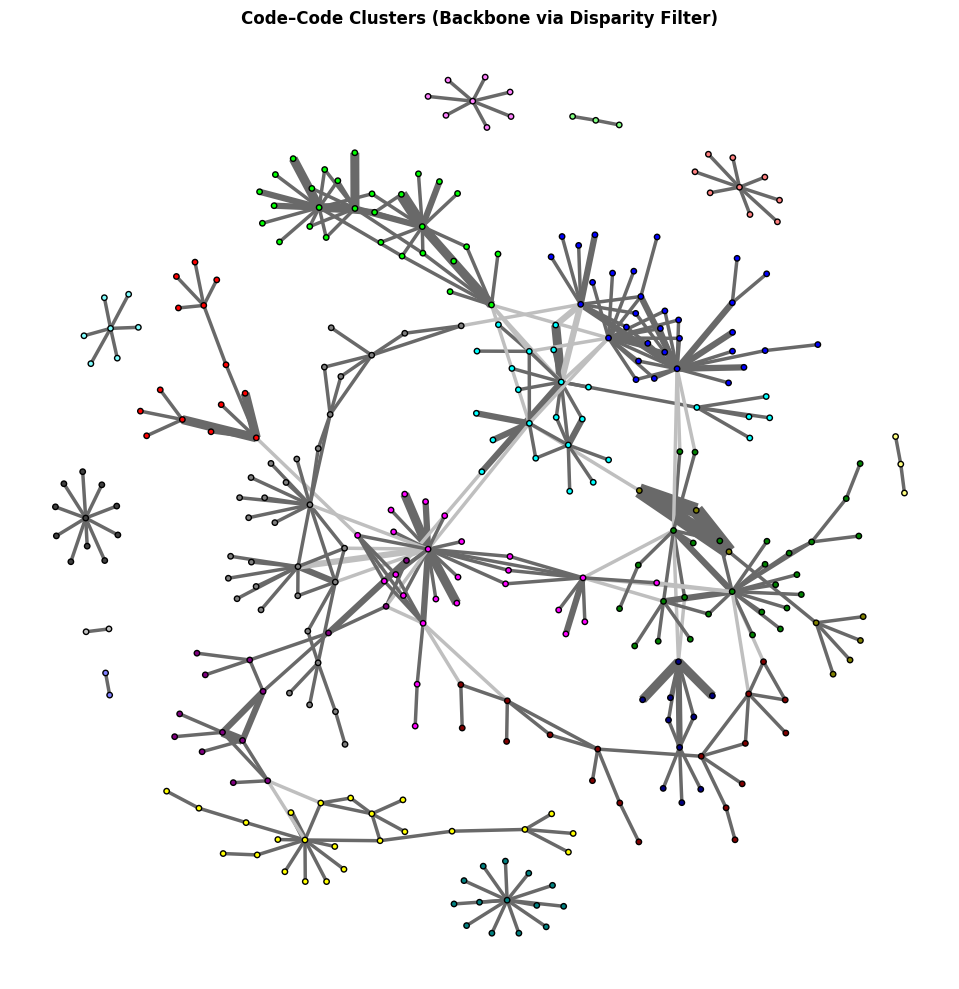

In [161]:
# Converti il grafo backbone di nuovo in igraph
backbone_ig = ig.Graph.from_networkx(backbone3)

# Community detection sul backbone
clusters_backbone = backbone_ig.community_multilevel(weights="weight")
backbone_ig.vs["cluster"] = clusters_backbone.membership

# Esempio d'uso con backbone_ig e soglia degree > 2
degree_threshold = 4
vertex_labels = labels_above_degree_threshold(code_graph, code_graph.vs["text"], degree_threshold)


# Plot
layout = backbone_ig.layout("fr")
fig, ax = plt.subplots(figsize=(12, 10))
ig.plot(
    clusters_backbone,
    layout=layout,
    #vertex_label=code_graph.vs["text"],
    target=ax,
    vertex_size=0.2,
    edge_width=[0.5 + 2 * w for w in backbone_ig.es["weight"]],
    bbox=(800, 800)
)
plt.title("Code–Code Clusters (Backbone via Disparity Filter)", fontweight="bold")
plt.tight_layout()
plt.show()

In [166]:
query_theme_codes(g, "opportunity", "perception", operation="intersection")

[('Code:communication', 2),
 ('Code:prior enabling posterior', 2),
 ('Code:timescale', 2),
 ('Code:charts', 2),
 ('Code:appropriate language', 2),
 ('Code:dissemination innovation is marketing', 2),
 ('Code:interactivity', 2),
 ('Code:available resources as assets', 2),
 ('Code:innovation is scientific or technical', 2),
 ('Code:failure as a measure of innovation', 2),
 ('Code:innovation is failure', 2),
 ('Code:innovation steps can be failures', 2),
 ('Code:lack of publication of negative results', 2),
 ('Code:negative results as assets', 2),
 ('Code:tracking innovation is a job', 2),
 ('Code:appropriate language to communicate oureach', 2),
 ('Code:innovation steps', 2),
 ('Code:learning', 2),
 ('Code:innovation steps as explainations', 2),
 ('Code:guided model', 2),
 ('Code:open access', 2),
 ('Code:policy', 2),
 ('Code:valuing authorship', 2),
 ('Code:decision making depending on roles', 2),
 ('Code:voting system as decision making', 2),
 ('Code:voting system moderated by experienc

In [48]:
get_sentences_linked_to_node(g, 'Code:roles and permissions governance')

Node 'Code:roles and permissions governance' not found in the graph.


[]

In [65]:
display(HTML(df_merged[df_merged['ThirdCC'].apply(lambda x : 'governance' in ', '.join(x))][['ID', 'Sentence', 'Themes']].to_html()))

In [1398]:
display(HTML(df_exploded[df_exploded['ThirdCC'] == 'roles and permissions governance'][['ID', 'Sentence']].to_html()))


In [46]:
from IPython.display import display, HTML

display(HTML(df_exploded[df_exploded['Themes'] == 'critics'][['ID', 'Sentence']].to_html()))


In [1374]:
set(df_exploded['Themes'])

{'',
 'appropriate language',
 'assets',
 'critics',
 'current situation',
 'disadvantages',
 'insight',
 'opportunity',
 'perception',
 'uncertainty'}

In [1435]:
df_exploded[df_exploded['Sentence'].astype(str).apply(lambda x : 'failure' in x)]

ID QID  QID_                                           Sentence  \
100   R1:25            Respondent - Well, it is not that failures are...   
100   R1:25            Respondent - Well, it is not that failures are...   
102   R1:27            Say, at the beginning of my PhD, I measured al...   
102   R1:27            Say, at the beginning of my PhD, I measured al...   
102   R1:27            Say, at the beginning of my PhD, I measured al...   
105   R1:30            So, I think that a complete measure of innovat...   
106   R1:31            First, because researchers do not publish fail...   
106   R1:31            First, because researchers do not publish fail...   
113   R1:41            Respondent - This is a wonderful question, bec...   
115   R1:43            So, from a point of view of scientific communi...   
453  R6:167      Q:35  Tracing innovation steps through results like ...   
453  R6:167      Q:35  Tracing innovation steps through results like ...   
453  R6:167      Q:35  Tracing innovation steps through results like ...   
541  R8:175      Q:34  Disadvantages for generic audiences: Non-exper...   
541  R8:175      Q:34  Disadvantages for generic audiences: Non-exper...   

                                                 Codes             Themes  \
100  {failure as a measure of innovation, innovatio...        opportunity   
100  {failure as a measure of innovation, innovatio...         perception   
102  {prior enabling posterior, timescale of months...            insight   
102  {prior enabling posterior, timescale of months...        opportunity   
102  {prior enabling posterior, timescale of months...  current situation   
105                                      {uncertainty}        uncertainty   
106  {scientific publications do not publish failures}        opportunity   
106  {scientific publications do not publish failures}        uncertainty   
113  {tracing innovation can be applied to both fai...        opportunity   
115                {utility of learning from failures}        opportunity   
453  {efficacy of using set of resources), meta-kno...            insight   
453  {efficacy of using set of resources), meta-kno...        opportunity   
453  {efficacy of using set of resources), meta-kno...             assets   
541  {unrealistic expectations, tracing innovation ...            critics   
541  {unrealistic expectations, tracing innovation ...      disadvantages   

                                               FirstCC  \
100  {failure as a measure of innovation, innovatio...   
100  {failure as a measure of innovation, innovatio...   
102  {prior enabling posterior, timescale of months...   
102  {prior enabling posterior, timescale of months...   
102  {prior enabling posterior, timescale of months...   
105                                      {uncertainty}   
106  {scientific publications do not publish failures}   
106  {scientific publications do not publish failures}   
113  {tracing innovation can be applied to both fai...   
115                {utility of learning from failures}   
453  {efficacy of using set of resources), meta-kno...   
453  {efficacy of using set of resources), meta-kno...   
453  {efficacy of using set of resources), meta-kno...   
541  {unrealistic expectations, tracing innovation ...   
541  {unrealistic expectations, tracing innovation ...   

                                              SecondCC  \
100  {innovation equated with failure, failure as i...   
100  {innovation equated with failure, failure as i...   
102  {prior steps enabling later outcomes, failure ...   
102  {prior steps enabling later outcomes, failure ...   
102  {prior steps enabling later outcomes, failure ...   
105                                      {uncertainty}   
106                      {non-publication of failures}   
106                      {non-publication of failures}   
113  {sufficiency of textual format, tracing failur...   
115                   {learning utility from failu